In [3]:
import xarray as xr
import os
import matplotlib.pyplot as plt
import numpy as np 

import pandas as pd 
import torch 
from tqdm import tqdm
from torch.optim import Adam
from torch.utils.data import DataLoader
import wandb
import argparse 
import importlib.util
import inspect
import random

from src.models.models_util import CESM_Dataset
from src.models.models import UNetRes3
from src.utils import util_cesm
from src import config_cesm
from src.models.losses import WeightedMSELoss
import src.config as config_era5

reference_grid = util_cesm.generate_sps_grid()

def roll_acc(acc):
    return xr.concat(
        [acc.roll(month=int(lt - 1), roll_coords=False).sel(lead_time=lt) for lt in acc.lead_time.values],
        dim="lead_time"
    )

def aggregate_acc(acc, dim):
    if dim == ("x", "y"):
        acc = acc.groupby("start_prediction_month.month").mean("start_prediction_month")
    else: 
        raise ValueError()
        
    # roll in lead time so that it gets lined up
    return roll_acc(acc)

def calculate_acc(pred_anom, truth_anom, aggregate, dim="start_prediction_month"):
    # Ensure dimensions match
    if pred_anom.dims != truth_anom.dims:
        raise ValueError("Predictions and truth must have the same dimensions.")

    acc = xr.cov(pred_anom, truth_anom, dim=dim) / (pred_anom.std(dim=dim) * truth_anom.std(dim=dim))

    if aggregate:
        acc = aggregate_acc(acc, dim)

    return acc

### Regrid obs

In [1]:
import xarray as xr
import xesmf as xe
import os
import numpy as np 
import pandas as pd 
import argparse 

from src.utils import util_cesm
from src import config_cesm
# import src.config as config_era5


In [17]:
cesm_to_era5_varnames = {
    "sst": "sea_surface_temperature",
    "icefrac": "sea_ice_cover",
    "psl": "mean_sea_level_pressure",
    "geopotential": "geopotential_500hPa",
    "t2m": "2m_temperature",
}

cesm_to_era5_short_varnames = {
    "sst": "sst",
    "icefrac": "siconc",
    "psl": "msl",
    "geopotential": "z",
    "t2m": "t2m"
}

def transform_obs_to_cesm_format(var_name, output_grid, savedir): 
    os.makedirs(savedir, exist_ok=True)
    savepath = os.path.join(savedir, f"{var_name}_obs.nc")
    if (os.path.exists(savepath)): return 

    ds = xr.open_dataset(os.path.join(config_cesm.DATA_DIRECTORY, f"ERA5/{cesm_to_era5_varnames[var_name]}.nc")).sel(latitude=slice(-30,-90))
    weight_file = f'{config_cesm.DATA_DIRECTORY}/cesm_lens/grids/era5_small_to_sps_bilinear_regridding_weights.nc'
    
    if os.path.exists(weight_file):
        regridder = xe.Regridder(ds, output_grid, 'bilinear', weights=weight_file, 
                                ignore_degenerate=True, reuse_weights=True, periodic=True)
    else:
        regridder = xe.Regridder(ds, output_grid, 'bilinear', filename=weight_file, 
                                ignore_degenerate=True, reuse_weights=False, periodic=True)
    ds_regridded = regridder(ds)
    ds_regridded = ds_regridded.sel(expver=1).combine_first(ds_regridded.sel(expver=5))

    # rename variable
    ds_regridded = ds_regridded.rename({cesm_to_era5_short_varnames[var_name]: var_name})

    # add a member_id dim
    ds_regridded = ds_regridded.assign_coords({"member_id": "obs"}).expand_dims("member_id")

    # save
    ds_regridded.to_netcdf(savepath)

In [18]:
sps_grid = util_cesm.generate_sps_grid()

for var_name in ["sst", "psl", "icefrac", "geopotential", "t2m"]:
    print(f"transforming {var_name}")
    transform_obs_to_cesm_format(var_name, sps_grid, os.path.join(config_cesm.DATA_DIRECTORY, "obs_data"))

transforming sst
transforming psl
transforming icefrac
transforming geopotential
transforming t2m


In [45]:
"member_id" in ds.indexes

False

### Data loader

In [4]:
ds = xr.open_dataset(os.path.join(config_cesm.DATA_DIRECTORY, f"ERA5/cesm_format/icefrac_obs.nc"))
ntime = len(ds.time) - 12 - 6

train_subset = np.arange(0, (7/10) * ntime, dtype=int)
val_subset = np.arange((7/10) * ntime, (8/10) * ntime, dtype=int)
test_subset = np.arange((8/10) * ntime, ntime, dtype=int)

data_split_settings = {
    "train": train_subset,
    "val": val_subset,
    "test": test_subset
}


def detrend_quadratic(da, time_dim='time'):
    time_vals = da[time_dim].dt.year + da[time_dim].dt.month / 12.0
    time_numeric = xr.DataArray(time_vals, coords={time_dim: da[time_dim]}, dims=time_dim)

    spatial_dims = [d for d in da.dims if d not in [time_dim, 'member_id']]
    da_stacked = da.stack(space=spatial_dims)
    detrended = da_stacked.copy()

    coeffs_all = []

    for month in range(1, 13):
        sel = da_stacked[time_dim].dt.month == month
        if not sel.any(): continue

        t = time_numeric.sel({time_dim: sel})
        Y = da_stacked.sel({time_dim: sel})
        X = np.stack([np.ones_like(t), t, t**2], axis=1)

        beta = np.linalg.solve(X.T @ X, X.T @ Y.values)  # (3, space)
        coeffs_all.append((month, beta))

        trend = xr.DataArray((X @ beta).astype(Y.dtype), coords=Y.coords, dims=Y.dims)
        detrended.loc[{time_dim: sel}] = da_stacked.sel({time_dim: sel}) - trend

    detrended_unstacked = detrended.unstack('space')

    # Build coeff DataArray
    coeffs = np.full((12, 3) + (da_stacked.sizes['space'],), np.nan, dtype=da.dtype)
    for month, beta in coeffs_all:
        coeffs[month - 1] = beta 

    coeff_da = xr.DataArray(
        coeffs,
        dims=('month', 'coeff', 'space'),
        coords={
            'month': np.arange(1, 13),
            'coeff': ['const', 'linear', 'quadratic'],
            'space': da_stacked.coords['space']
        }
    ).unstack('space')

    return detrended_unstacked, coeff_da

def load_data_da_dict(config, use_cesm_climatology=False, cesm_climatology_dir=None, 
                     detrend=False):
    data_da_dict = {}

    for var_name in config.INPUT_CONFIG.keys(): 
        if config.INPUT_CONFIG[var_name]['include'] and config.INPUT_CONFIG[var_name]['norm']:
            max_lag_months = config.INPUT_CONFIG[var_name]['lag']
            divide_by_stdev = config.INPUT_CONFIG[var_name]['divide_by_stdev']
            use_min_max = config.INPUT_CONFIG[var_name]["use_min_max"]

            # Load the observational data
            ds = xr.open_dataset(os.path.join(config_cesm.DATA_DIRECTORY, f"ERA5/cesm_format/{var_name}_obs.nc"))
            obs_da = ds[var_name] 
            months = obs_da['time'].dt.month
            da_train_subset = obs_da[np.concatenate((np.arange(12, dtype=int), train_subset + int(12)))]

            if divide_by_stdev: 
                normalized_da = (obs_da - monthly_means.sel(month=months)) / monthly_stdev.sel(month=months)
            else:    
                if use_min_max:
                    print(f"normalizing {var_name} with min max")
                    monthly_mins = da_train_subset.groupby("time.month").min(dim=("time")).load()
                    monthly_maxs = da_train_subset.groupby("time.month").max(dim=("time")).load()
                    normalized_da = (obs_da - monthly_mins.sel(month=months)) / (monthly_maxs.sel(month=months) - monthly_mins.sel(month=months))
                else:
                    if use_cesm_climatology:
                        monthly_means = xr.open_dataset(os.path.join(cesm_climatology_dir, f"{var_name}_mean.nc"))[var_name]
                    else:
                        monthly_means = da_train_subset.groupby("time.month").mean(dim="time").load()
                    normalized_da = obs_da - monthly_means.sel(month=months)
            
            if detrend: 
                normalized_da, coeffs = detrend_quadratic(normalized_da)

            # artificial cap: sst to [-5, 5]
            if var_name == "temp":
                normalized_da = xr.where(normalized_da > 5, 5, normalized_da)
                normalized_da = xr.where(normalized_da < -5, -5, normalized_da)
            data_da_dict[var_name] = normalized_da.drop_vars("month")

    return data_da_dict

def get_obs_start_prediction_months(data_da_dict, data_split_settings):
    max_lag = 12
    first_month = data_da_dict["icefrac"].time[max_lag].item()
    last_month = data_da_dict["icefrac"].time[-config.MAX_LEAD_MONTHS].item()
    return pd.date_range(first_month, last_month, freq="MS")


def save_obs_inputs(input_config, save_path, data_da_dict, data_split_settings):
    """
    Writes a model-ready input file (.nc) for each ensemble member to save_path

    Param:
        (dict)      input_config
        (string)    save_path
    """

    # get some auxiliary data
    x_coords = data_da_dict["icefrac"].x.data
    y_coords = data_da_dict["icefrac"].y.data
    land_mask = np.isnan(data_da_dict["icefrac"].isel(time=0)).data
    land_mask = np.transpose(land_mask.reshape(1, 80, 80), [0, 2, 1]) # for some reason, x and y get switched

    start_prediction_months = get_obs_start_prediction_months(data_da_dict, data_split_settings)
    save_name = os.path.join(save_path, f"inputs_obs.nc")
    if os.path.exists(save_name):
       return

    da_list = []
    for start_prediction_month in start_prediction_months:
        time_da_list = []
        for input_var, input_var_params in input_config.items():
            if not input_var_params["include"]: 
                continue 
            
            if not input_var_params["auxiliary"]:
                prediction_input_months = pd.date_range(start_prediction_month - pd.DateOffset(months=input_var_params["lag"]), 
                                                        start_prediction_month - pd.DateOffset(months=1), freq="MS")

                input_data = data_da_dict[input_var].sel(time=prediction_input_months)

                # mask out NaN values
                input_data = input_data.fillna(0)

                # rename the time coordinate to channel 
                lag = input_var_params["lag"]
                input_data = input_data.assign_coords(time=[f"{input_var}_lag{lag+1-i}" for i in range(1, lag+1)])
                input_data = input_data.rename({"time": "channel"})
            else:
                if input_var == "cosine_of_init_month":
                    input_data = xr.DataArray(
                        np.full((1, 80, 80), np.cos(2 * np.pi * start_prediction_month.month / 12)),
                        dims=["channel", "x", "y"],
                        coords={"channel": [input_var], "x": x_coords, "y": y_coords},
                    )
                elif input_var == "sine_of_init_month":
                    input_data = xr.DataArray(
                        np.full((1, 80, 80), np.sin(2 * np.pi * start_prediction_month.month / 12)),
                        dims=["channel", "x", "y"],
                        coords={"channel": [input_var], "x": x_coords, "y": y_coords},
                    )
                elif input_var == "land_mask": 
                    input_data = xr.DataArray(
                        land_mask, 
                        dims=["channel", "x", "y"],
                        coords={"channel": [input_var], "x": x_coords, "y": y_coords},
                    )
                else: 
                    raise NotImplementedError()

            # add a coordinate to denote the start prediction month (time origin)
            input_data = input_data.assign_coords(start_prediction_month=start_prediction_month)

            time_da_list.append(input_data)

        da_list.append(xr.concat(time_da_list, dim="channel", coords='minimal', compat='override'))

    da_merged = xr.concat(da_list, dim="start_prediction_month", coords="minimal", compat='override')

    # rechunk
    da_merged = da_merged.chunk(chunks={"start_prediction_month":12, "channel":-1})

    # clean up singleton dimensions
    if "z_t" in da_merged.dims: 
        da_merged = da_merged.drop_vars("z_t")
    if "lev" in da_merged.dims:
        da_merged = da_merged.drop_vars("lev")


    print("done! Saving...")
    da_merged.to_dataset(name="data").to_netcdf(save_name)
    da_merged.close()


def save_obs_targets(input_da_dict, input_config, target_config, 
                    save_path, max_lead_months, data_split_settings):
    """
    Writes a model-ready targets file (.nc) for each ensemble member to save_path
    
    Param:
        (dict)      input_config
        (dict)      target_config
        (string)    save_path
        (int)       max_lead_months
        (dict)      data_split_settings
    """

    if not target_config["predict_anom"]:
        raise NotImplementedError()
    else:
        da = input_da_dict["icefrac"]

    start_prediction_months = get_obs_start_prediction_months(input_da_dict, data_split_settings)
    save_name = os.path.join(save_path, f"targets_obs.nc")
    if os.path.exists(save_name):
        return

    time_da_list = []

    for start_prediction_month in start_prediction_months:
        prediction_target_months = pd.date_range(start_prediction_month, 
                                                start_prediction_month + pd.DateOffset(months=max_lead_months-1), 
                                                freq="MS")
        
        target_data = da.sel(time=prediction_target_months)

        # mask out nans
        target_data = target_data.fillna(0)

        target_data = target_data.assign_coords(time=np.arange(1,7))
        target_data = target_data.rename({"time": "lead_time"}) 

        # add a coordinate to denote the start prediction month (time origin)
        target_data = target_data.assign_coords(start_prediction_month=start_prediction_month)

        time_da_list.append(target_data)

    da_merged = xr.concat(time_da_list, dim="start_prediction_month", coords='minimal', compat='override')

    da_merged = da_merged.chunk(chunks={"start_prediction_month":12, "lead_time":-1})
    
    da_merged.to_dataset(name="data").to_netcdf(save_name)
    da_merged.close()




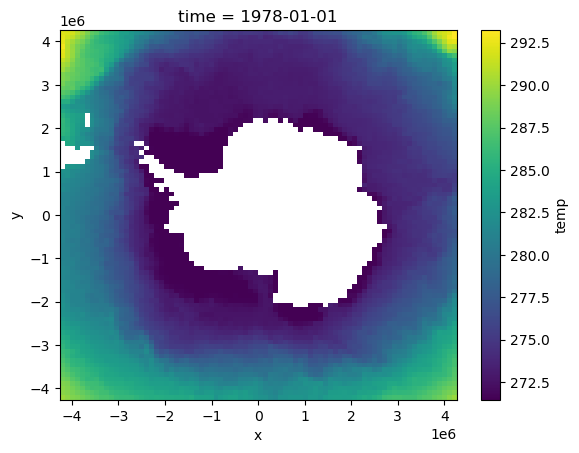

In [7]:
import xarray as xr
ds = xr.open_dataset("/oak/stanford/groups/earlew/yuchen/ERA5/cesm_format/temp_obs.nc")

ds["temp"].isel(time=0).plot()

In [10]:
import src.experiment_configs.exp1_inputs.input2 as config2

# the climatology for the largest training run 
cesm_clim_dir = "/scratch/users/yucli/cesm_data_processed/normalized_inputs/seaice_plus_auxiliary_vol4_dt"

for config in [config2]:
    save_path = os.path.join(config_cesm.PROCESSED_DATA_DIRECTORY, "data_pairs", 
                             "seaice_plus_auxiliary_cesmclim")
    os.makedirs(save_path, exist_ok=True)

    data_da_dict = load_data_da_dict(config, use_cesm_climatology=True, cesm_climatology_dir=cesm_clim_dir,
                                    detrend=False)

    save_obs_inputs(config.INPUT_CONFIG, save_path, data_da_dict, data_split_settings)

    save_obs_targets(data_da_dict, config.INPUT_CONFIG, config.TARGET_CONFIG, 
                    save_path, 6, data_split_settings)


done! Saving...


In [5]:

class Obs_Dataset(torch.utils.data.Dataset):
    def __init__(self, split, data_config_name, data_split_settings, data_dir=None):
        if data_dir is not None:
            self.data_dir = data_dir
        else:
            self.data_dir = os.path.join(config_cesm.PROCESSED_DATA_DIRECTORY, "data_pairs", data_config_name)
            
        self.split = split

        # Open and keep datasets in memory
        self.inputs = xr.open_dataset(os.path.join(self.data_dir, "inputs_obs.nc")).data
        self.targets = xr.open_dataset(os.path.join(self.data_dir, "targets_obs.nc")).data

        # Build a global index of samples
        time_values = self.inputs["start_prediction_month"].values
        self.samples = [(time_values[start_idx], int(start_idx)) for start_idx in data_split_settings[split]]

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        start_prediction_month, start_idx = self.samples[idx]

        input_sample = self.inputs.isel(start_prediction_month=start_idx).load().values.copy()
        target_sample = self.targets.isel(start_prediction_month=start_idx).load().values.copy()

        max_lead_months = target_sample.shape[0]
        start_prediction_months = pd.date_range(
            start_prediction_month,
            start_prediction_month + pd.DateOffset(months=max_lead_months - 1),
            freq="MS"
        )

        time_npy = np.column_stack((start_prediction_months.year, start_prediction_months.month))

        sample = {
            "input": torch.tensor(input_sample, dtype=torch.float32),
            "target": torch.tensor(target_sample, dtype=torch.float32),
            "start_prediction_month": time_npy,
        }

        return sample


In [6]:
def train_epoch(model, dataloader, optimizer, loss_fn, device, epoch, total_epochs, global_step):
    model.train()
    epoch_loss = 0
    loss_fn_params = inspect.signature(loss_fn.forward).parameters

    progress_bar = tqdm(enumerate(dataloader), total=len(dataloader), desc=f"Epoch {epoch}/{total_epochs} [Train]")

    for _, batch in progress_bar:
        inputs, targets = batch["input"].to(device), batch["target"].to(device)

        optimizer.zero_grad()
        predictions = model(inputs)

        loss_kwargs = {"prediction": predictions, "target": targets}
        if "target_months" in loss_fn_params:
            loss_kwargs["target_months"] = batch["start_prediction_month"][:, :, 1].to(device)

        loss = loss_fn(**loss_kwargs)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        progress_bar.set_postfix({"Batch Loss": loss.item()})

        # Log batch-level training loss
        wandb.log({"train_loss": loss.item()}, step=global_step)
        global_step += 1

    return epoch_loss / len(dataloader), global_step

def validate_epoch(model, dataloader, loss_fn, device, epoch, total_epochs, global_step):
    model.eval()
    total_squared_error = 0.0
    total_count = 0
    epoch_loss = 0 
    loss_fn_params = inspect.signature(loss_fn.forward).parameters

    progress_bar = tqdm(enumerate(dataloader), total=len(dataloader), desc=f"Epoch {epoch}/{total_epochs} [Val]")

    with torch.no_grad():
        for _, batch in progress_bar:
            inputs, targets = batch["input"].to(device), batch["target"].to(device)
            predictions = model(inputs)

            # Compute loss 
            loss_kwargs = {"prediction": predictions, "target": targets}
            if "target_months" in loss_fn_params:
                loss_kwargs["target_months"] = batch["start_prediction_month"][:, :, 1].to(device)
            loss = loss_fn(**loss_kwargs)

            # Compute RMSE
            squared_error = (predictions - targets) ** 2
            total_squared_error += squared_error.sum().item()
            total_count += targets.numel()

            batch_rmse = torch.sqrt(squared_error.mean()).item()
            progress_bar.set_postfix({"Batch RMSE": batch_rmse})
            wandb.log({
                "val_loss": loss.item(),
                "val_rmse": batch_rmse
            }, step=global_step)
            
            epoch_loss += loss.item()
            global_step += 1

    epoch_rmse = (total_squared_error / total_count) ** 0.5
    return epoch_rmse, epoch_loss / len(dataloader), global_step

from torch.optim.lr_scheduler import CosineAnnealingLR

def train(data_config, save_path, architecture, finetune_model_path=None):
    wandb.init(settings=wandb.Settings(console="off"))
    config = wandb.config
    train_dataset = Obs_Dataset("train", data_config.DATA_CONFIG_NAME, data_split_settings)
    val_dataset = Obs_Dataset("val", data_config.DATA_CONFIG_NAME, data_split_settings)

    train_dataloader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True, num_workers=0)
    val_dataloader = DataLoader(val_dataset, batch_size=config.batch_size, shuffle=False, num_workers=0)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    in_channels = util_cesm.get_num_input_channels(data_config.INPUT_CONFIG)
    out_channels = util_cesm.get_num_output_channels(data_config.MAX_LEAD_MONTHS, data_config.TARGET_CONFIG)

    if finetune_model_path is None:
        if architecture == "UNetRes3":
            model = UNetRes3(
                in_channels=in_channels, 
                out_channels=out_channels, 
                n_channels_factor=config.n_channels_factor,
                predict_anomalies=data_config.TARGET_CONFIG["predict_anom"]
            ).to(device)
        elif architecture == "SICNet_TSAM": 
            # Warning: hardcoded values for testing
            model = SICNet(T=12, T_pred=6).to(device)
    else:
        # TODO: implement diff architectures (if necessary)
        # load finetuned model
        checkpoint = torch.load(finetune_model_path, map_location=device, weights_only=True)
        model = UNetRes3(in_channels=in_channels, 
                        out_channels=out_channels, 
                        predict_anomalies=True).to(device)
        model.load_state_dict(checkpoint["model_state_dict"])

    optimizer = Adam(model.parameters(), lr=config.lr, weight_decay=config.weight_decay)
    scheduler = CosineAnnealingLR(optimizer, T_max=config.num_epochs)

    loss_function_args = data_config.LOSS_FUNCTION_ARGS 
    loss_function_args["apply_month_weights"] = bool(config.loss_function_args)
    loss_fn = WeightedMSELoss(device=device, model=model, **loss_function_args)

    num_epochs = config.num_epochs
    global_step = 0
    best_val_rmse = float('inf')
    run_id = wandb.run.id 
    best_model_path = os.path.join(save_path, f"{data_config.DATA_CONFIG_NAME}_{run_id}_best.pt")
    patience = 5
    patience_counter = 0

    for epoch in range(num_epochs):
        train_loss, global_step = train_epoch(
            model, train_dataloader, optimizer, loss_fn, device, epoch, num_epochs, global_step
        )

        val_rmse, val_loss, global_step = validate_epoch(
            model, val_dataloader, loss_fn, device, epoch, num_epochs, global_step
        )

        # Log epoch stats and learning rate
        current_lr = scheduler.get_last_lr()[0]
        wandb.log({
            "epoch": epoch,
            "epoch_train_loss": train_loss,
            "epoch_val_loss": val_loss, 
            "epoch_val_rmse": val_rmse,
            "lr": current_lr,
        }, step=global_step)

        scheduler.step()

        # Early stopping 
        if val_rmse < best_val_rmse:
            best_val_rmse = val_rmse
            torch.save(model.state_dict(), best_model_path)
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping triggered at epoch {epoch+1}")
                break
        
        if best_val_rmse < float("inf"):
            wandb.log({"best_val_rmse": best_val_rmse}, step=global_step)

def evaluate(model, dataloader):
    channels, x_dim, y_dim = 6, 80, 80

    pred_list = []
    truth_list = []
    time_list = []

    # Populate the Dataset with predictions
    with torch.no_grad():
        for batch in dataloader:
            inputs = batch["input"].to(device)
            targets = batch["target"]
            predictions = model(inputs).cpu().numpy()

            # since batch size = 1, get the only sample in the batch
            predictions = predictions[0]
            targets = targets[0]

            # Extract metadata
            start_year, start_month = batch["start_prediction_month"].cpu().numpy()[0, 0]
            start_prediction_month = pd.Timestamp(year=start_year, month=start_month, day=1)
            time_list.append(start_prediction_month)

            pred_da = xr.DataArray(
                predictions,
                dims=["lead_time", "y", "x"],
                coords={
                    "lead_time": np.arange(1, channels + 1),
                    "y": reference_grid.y.values,
                    "x": reference_grid.x.values,
                }
            )
            truth_da = xr.DataArray(
                targets,
                dims=["lead_time", "y", "x"],
                coords={
                    "lead_time": np.arange(1, channels + 1),
                    "y": reference_grid.y.values,
                    "x": reference_grid.x.values,
                }
            )

            pred_list.append(pred_da)
            truth_list.append(truth_da)

    # Stack results along new time coordinate
    ds_pred = xr.Dataset({
        "icefrac": xr.concat(pred_list, dim=pd.Index(time_list, name="start_prediction_month"))
    })
    ds_truth = xr.Dataset({
        "icefrac": xr.concat(truth_list, dim=pd.Index(time_list, name="start_prediction_month"))
    })

    return ds_pred, ds_truth


## Sweep 1 (input2)
Results at https://wandb.ai/ychnli-stanford-university/sea-ice-prediction/sweeps/ki0k0l49

In [ ]:
import src.experiment_configs.exp1_inputs.input4 as config4
import src.experiment_configs.exp1_inputs.input2 as config2

data_config = config2

sweep_config = {
    'method': 'random', 
    'metric': {
        'name': 'epoch_val_rmse',
        'goal': 'minimize'
    },
    'parameters': {
        'lr': {
            'min': 1e-5,
            'max': 5e-3 
        },
        'weight_decay': {
            'min': 0.0,
            'max': 1e-3
        },
        'batch_size': {
            'values': [1, 2, 4, 8, 16, 32, 64] 
        },
        'n_channels_factor': {
            'values': [0.5, 0.75, 1]
        },
        'num_epochs': {
            'value': 50
        },
        'loss_function_args': {
            'values': [0, 1] # 0 = don't apply monthly weights; 1 = apply monthly weights
        }
    }
}

sweep_id = wandb.sweep(sweep_config, project="sea-ice-prediction")

save_path = "/scratch/users/yucli/sicpred_models/exp3_obs_hypsweep"
wandb.agent(sweep_id, function=lambda: train(data_config, save_path=save_path), count=50)


## Sweep 2 (input2)
Refined ranges (removed large learning rates, use larger batch sizes)

Results: https://wandb.ai/ychnli-stanford-university/sea-ice-prediction/sweeps/85pc8f4o

In [ ]:
import src.experiment_configs.exp1_inputs.input4 as config4
import src.experiment_configs.exp1_inputs.input2 as config2

data_config = config2

sweep_config = {
    'method': 'random', 
    'metric': {
        'name': 'best_val_rmse',
        'goal': 'minimize'
    },
    'parameters': {
        'lr': {
            'min': 1e-5,
            'max': 2e-3 
        },
        'weight_decay': {
            'min': 0.0,
            'max': 1e-4
        },
        'batch_size': {
            'values': [20, 32, 50, 64] 
        },
        'n_channels_factor': {
            'values': [0.5, 0.75, 1]
        },
        'num_epochs': {
            'value': 100
        },
        'loss_function_args': {
            'value': 1
        }
    }
}

sweep_id = wandb.sweep(sweep_config, project="sea-ice-prediction")

save_path = "/scratch/users/yucli/sicpred_models/exp3_obs_hypsweep"
wandb.agent(sweep_id, function=lambda: train(data_config, save_path=save_path), count=50)


## Try a different model

In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# class TemporalAttention2D(nn.Module):
#     def __init__(self, T):
#         super().__init__()
#         kernel_size = max(1, T // 2)
#         self.tcn1 = nn.Conv1d(T, 8, kernel_size=kernel_size, padding='same', dilation=1)
#         self.tcn2 = nn.Conv1d(8, 8, kernel_size=kernel_size, padding='same', dilation=2)
#         self.tcn3 = nn.Conv1d(8, T, kernel_size=kernel_size, padding='same', dilation=4)

#     def forward(self, x):  # x: (N, T, H, W)
#         print(x.shape)
#         B, T, H, W = x.shape
#         avg_pool = torch.mean(x.view(B, T, -1), dim=2)  # (B, T)
#         print(avg_pool.shape)
#         y = self.tcn1(avg_pool.unsqueeze(1))
#         y = self.tcn2(y)
#         y = self.tcn3(y)
#         attn = torch.sigmoid(y).squeeze(1).unsqueeze(-1).unsqueeze(-1)  # (B, T, 1, 1)
#         return x * attn

# class SpatialAttention2D(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.conv = nn.Conv2d(2, 1, kernel_size=7, padding=3)

#     def forward(self, x):  # x: (N, T, H, W)
#         avg_pool = torch.mean(x, dim=1, keepdim=True)  # (N, 1, H, W)
#         max_pool, _ = torch.max(x, dim=1, keepdim=True)  # (N, 1, H, W)
#         concat = torch.cat([avg_pool, max_pool], dim=1)
#         attn = torch.sigmoid(self.conv(concat))  # (N, 1, H, W)
#         return x * attn

# class TSAM2D(nn.Module):
#     def __init__(self, T):
#         super().__init__()
#         self.temporal = TemporalAttention2D(T)
#         self.spatial = SpatialAttention2D()

#     def forward(self, x):
#         x = self.temporal(x)
#         x = self.spatial(x)
#         return x

from torch.nn.utils import weight_norm

class Convblock(nn.Module):
    def __init__(self,in_channel,out_channel):
        super(Convblock,self).__init__()
        self.out_c = out_channel
        self.in_c = in_channel
        self.conv2d = nn.Conv2d(self.in_c,self.out_c,3,stride=1,padding=1)
        self.batchnorm = nn.BatchNorm2d(out_channel)
        self.relu = nn.ReLU()

    def forward(self,x):
        x = self.conv2d(x)
        x = self.batchnorm(x)
        x = self.relu(x)
        return x

class Chomp1d(nn.Module):
    def __init__(self, chomp_size):
        super(Chomp1d, self).__init__()
        self.chomp_size = chomp_size

    def forward(self, x):
        if self.chomp_size != 0:
            x = x[:, :, :-self.chomp_size].contiguous()
        else: x 
        return x

class TemporalBlock(nn.Module):
    def __init__(self, n_inputs, n_outputs, kernel_size, stride, dilation, padding):
        super(TemporalBlock, self).__init__()
        self.conv1 = weight_norm(nn.Conv1d(n_inputs, n_outputs, kernel_size,
                                           stride=stride, padding=padding, dilation=dilation))
        self.chomp1 = Chomp1d(padding)
        self.relu1 = nn.ReLU()

        self.conv2 = weight_norm(nn.Conv1d(n_outputs, n_outputs, kernel_size,
                                           stride=stride, padding=padding, dilation=dilation))
        self.chomp2 = Chomp1d(padding)
        self.relu2 = nn.ReLU()

        self.net = nn.Sequential(self.conv1, self.chomp1, self.relu1,
                                 self.conv2, self.chomp2, self.relu2)
        self.downsample = nn.Conv1d(n_inputs, n_outputs, 1) if n_inputs != n_outputs else None
        self.relu = nn.ReLU()
        self.init_weights()

    def init_weights(self):
        self.conv1.weight.data.normal_(0, 0.01)
        self.conv2.weight.data.normal_(0, 0.01)
        if self.downsample is not None:
            self.downsample.weight.data.normal_(0, 0.01)

    def forward(self, x):
        out = self.net(x)
        res = x if self.downsample is None else self.downsample(x)
        return self.relu(out + res)

class TCN(nn.Module):
    def __init__(self, num_inputs, num_channels, kernel_size):
        super(TCN, self).__init__()
        layers = []
        num_levels = len(num_channels)
        for i in range(num_levels):
            dilation_size = 2 ** i
            in_channels = num_inputs if i == 0 else num_channels[i-1]
            out_channels = num_channels[i]
            layers += [TemporalBlock(in_channels, out_channels, kernel_size, stride=1, dilation=dilation_size,
                                     padding=(kernel_size-1) * dilation_size)]

        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

class TSAM(nn.Module):
    def __init__(self, channels):
        super(TSAM, self).__init__()
        self.channels = channels
        kernel_size_tcn = max(channels // 12, 1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        self.avg_pool = nn.AdaptiveAvgPool2d(1)

        self.max_tcn1 = TCN(num_inputs = 1, num_channels = [8,8,8], kernel_size = channels//12)
        self.max_tcn2 = TCN(num_inputs = 8, num_channels = [8,8,8], kernel_size = channels//12)
        self.max_tcn3 = TCN(num_inputs = 8, num_channels = [1,1], kernel_size = 1)
        self.avg_tcn1 = TCN(num_inputs = 1, num_channels = [8,8,8], kernel_size = channels//12)
        self.avg_tcn2 = TCN(num_inputs = 8, num_channels = [8,8,8], kernel_size = channels//12)
        self.avg_tcn3 = TCN(num_inputs = 8, num_channels = [1,1], kernel_size= 1)
        self.spatial_conv = nn.Conv2d(2, 1, kernel_size=7, padding=3, bias=False)

        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        max_pooled = self.max_pool(x)

        avg_pooled = self.avg_pool(x)

        max_out = self.max_tcn3(self.max_tcn2(self.max_tcn1(torch.squeeze(max_pooled,-1).permute(0,2,1)))).permute(0,2,1)
        avg_out = self.avg_tcn3(self.avg_tcn2(self.avg_tcn1(torch.squeeze(avg_pooled,-1).permute(0,2,1)))).permute(0,2,1)

        tcn_out = max_out + avg_out
        tcn_attention = self.sigmoid(tcn_out.unsqueeze(-1))
        x = tcn_attention * x

        max_pool = torch.max(x, dim=1, keepdim=True)[0]
        avg_pool = torch.mean(x, dim=1, keepdim=True)
        pool_cat = torch.cat([max_pool, avg_pool], dim=1)
        spatial_attention = self.spatial_conv(pool_cat)

        x = x * self.sigmoid(spatial_attention)

        return x

class CNNTSAMBlock(nn.Module):
    def __init__(self, in_channels, out_channels, T):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn = nn.BatchNorm2d(out_channels)
        self.tsam = TSAM(T)

    def forward(self, x):
        x = F.relu(self.bn(self.conv(x)))
        return self.tsam(x)

class ResNetTSAMBlock(nn.Module):
    def __init__(self, in_channels, out_channels, T):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.tsam = TSAM(T)
        self.need_proj = in_channels != out_channels
        if self.need_proj:
            self.proj = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        identity = x
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out = self.tsam(out)
        if self.need_proj:
            identity = self.proj(identity)
        return F.relu(out + identity)

class SICNet(nn.Module):
    def __init__(self, T, T_pred, clip_near_zero_values=True, epsilon=0.01):
        super().__init__()
        base = 16
        self.T, self.T_pred = T, T_pred
        self.clip_near_zero_values = clip_near_zero_values
        self.epsilon = epsilon

        self.enc1 = CNNTSAMBlock(T, base*2, T)
        self.pool1 = nn.MaxPool2d(2)
        self.enc2 = nn.Sequential(
            ResNetTSAMBlock(base*2, base*4, T), ResNetTSAMBlock(base*4, base*4, T))

        self.pool2 = nn.MaxPool2d(2)
        self.enc3 = nn.Sequential(
            ResNetTSAMBlock(base*4, base*6, T), ResNetTSAMBlock(base*6, base*6, T))

        self.pool3 = nn.MaxPool2d(2)
        self.enc4 = nn.Sequential(
            ResNetTSAMBlock(base*6, base*8, T), ResNetTSAMBlock(base*8, base*8, T))

        self.pool4 = nn.MaxPool2d(2)
        self.enc5 = nn.Sequential(
            ResNetTSAMBlock(base*8, base*10, T), ResNetTSAMBlock(base*10, base*10, T))

        self.up4 = nn.Upsample(scale_factor=2, mode='nearest')
        self.dec4 = ResNetTSAMBlock(base*10 + base*8, base*8, T)
        self.up3 = nn.Upsample(scale_factor=2, mode='nearest')
        self.dec3 = ResNetTSAMBlock(base*8 + base*6, base*6, T)
        self.up2 = nn.Upsample(scale_factor=2, mode='nearest')
        self.dec2 = ResNetTSAMBlock(base*6 + base*4, base*4, T)
        self.up1 = nn.Upsample(scale_factor=2, mode='nearest')
        self.dec1 = ResNetTSAMBlock(base*4 + base*2, base*2, T)

        self.out_conv = nn.Conv2d(base*2, T_pred, kernel_size=1)

        land_mask = self.create_inverted_land_mask()
        self.register_buffer("land_mask", land_mask)

    def create_inverted_land_mask(self):
        try: 
            ds = xr.open_dataset(os.path.join(config_cesm.DATA_DIRECTORY, "cesm_lens/grids/icefrac_land_mask.nc"))
        except:
            raise Exception("Uh oh, seems like you still need to run the preprocess script to generate \
                an icefrac land mask. See src/util_cesm for the function")

        mask = ~ds.mask.values.astype(bool)  # invert land mask
        return torch.from_numpy(mask).float().unsqueeze(0).repeat(self.T_pred, 1, 1)

    def forward(self, x):  # x: (N, T, H, W)
        e1 = self.enc1(x)
        p1 = self.pool1(e1)
        e2 = self.enc2(p1)
        p2 = self.pool2(e2)
        e3 = self.enc3(p2)
        p3 = self.pool3(e3)
        e4 = self.enc4(p3)
        p4 = self.pool4(e4)
        e5 = self.enc5(p4)

        d4 = self.up4(e5)
        d4 = self.dec4(torch.cat([d4, e4], dim=1))
        d3 = self.up3(d4)
        d3 = self.dec3(torch.cat([d3, e3], dim=1))
        d2 = self.up2(d3)
        d2 = self.dec2(torch.cat([d2, e2], dim=1))
        d1 = self.up1(d2)
        d1 = self.dec1(torch.cat([d1, e1], dim=1))

        out = torch.tanh(self.out_conv(d1))  # (N, T_pred, H, W)

        if self.clip_near_zero_values:
            out = out.where(out.abs() > self.epsilon, 0)

        out = out * self.land_mask.unsqueeze(0)  # (1, T_pred, H, W)
        return out

model = SICNet(T=12, T_pred=6)
print(sum(p.numel() for p in model.parameters() if p.requires_grad))


/home/groups/earlew/yuchen/miniconda3/envs/sicpred_env_conda/lib/python3.12/site-packages/torch/nn/utils/weight_norm.py:143: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)


2933608


In [21]:
x = torch.randn(2, 12, 80, 80)  # (N, T, H, W)
model(x).shape

torch.Size([2, 6, 80, 80])

In [26]:
import src.experiment_configs.tests.input2 as config2
data_config = config2

sweep_config = {
    'method': 'random', 
    'metric': {
        'name': 'best_val_rmse',
        'goal': 'minimize'
    },
    'parameters': {
        'lr': {
            'min': 1e-5,
            'max': 2e-3 
        },
        'weight_decay': {
            'min': 0.0,
            'max': 1e-4
        },
        'batch_size': {
            'values': [20, 32, 50, 64] 
        },
        'num_epochs': {
            'value': 100
        },
        'loss_function_args': {
            'value': 0
        }
    }
}

sweep_id = wandb.sweep(sweep_config, project="sea-ice-prediction")

save_path = "/scratch/users/yucli/sicpred_models/exp3_obs_tsam_hypsweep"
os.makedirs(save_path, exist_ok=True)

wandb.agent(sweep_id, function=lambda: train(data_config, save_path=save_path, architecture="SICNet_TSAM"), count=25)


Create sweep with ID: 70ww3ii3
Sweep URL: https://wandb.ai/ychnli-stanford-university/sea-ice-prediction/sweeps/70ww3ii3


wandb: Agent Starting Run: nalqert0 with config:
wandb: 	batch_size: 20
wandb: 	loss_function_args: 0
wandb: 	lr: 0.0017262115514815443
wandb: 	num_epochs: 100
wandb: 	weight_decay: 7.876043007272442e-05


/home/groups/earlew/yuchen/miniconda3/envs/sicpred_env_conda/lib/python3.12/site-packages/torch/nn/utils/weight_norm.py:143: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)
Epoch 16/100 [Val]: 100%|██████████| 3/3 [00:00<00:00,  9.21it/s, Batch RMSE=0.0808]


Early stopping triggered at epoch 17


best_val_rmse,█▆▅▃▃▂▂▂▂▂▂▁▁▁▁▁
epoch,▁▁▂▂▃▃▄▄▅▅▅▆▆▇▇██
epoch_train_loss,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch_val_loss,█▆▅▃▄▂▂▃▂▂▂▁▂▁▂▂▂
epoch_val_rmse,█▆▅▃▄▂▂▃▂▂▂▁▂▁▂▂▂
lr,█████▇▇▇▆▆▅▅▄▃▃▂▁
train_loss,█▄▃▄▃▄▄▂▅▅▄▄▂▃▆▃▃▃▂▄▃▂▃▁▄▄▂▂▂▅▅▂▁▃▂▂▃▄▂▄
val_loss,█▆█▇▅▆▄▅▅▃▅▄▅▃▂▂▂▃▃▅▃▅▃▃▄▅▂▁▅▃▄▂▂▅▃▄▃▃▅▂
val_rmse,██▇▅▇▅▅▅▃▄▄▅▅▃▂▃▂▅▃▃▃▃▅▃▃▃▃▅▂▁▂▅▂▂▅▃▄▃▃▂
best_val_rmse,0.08269
epoch,16


wandb: Agent Starting Run: 9qph0pg6 with config:
wandb: 	batch_size: 20
wandb: 	loss_function_args: 0
wandb: 	lr: 0.00029402149037361053
wandb: 	num_epochs: 100
wandb: 	weight_decay: 8.150560597284258e-05


/home/groups/earlew/yuchen/miniconda3/envs/sicpred_env_conda/lib/python3.12/site-packages/torch/nn/utils/weight_norm.py:143: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)
Epoch 16/100 [Val]: 100%|██████████| 3/3 [00:00<00:00,  9.85it/s, Batch RMSE=0.0862]


Early stopping triggered at epoch 17


best_val_rmse,█▄▃▂▂▂▂▂▂▂▂▁▁▁▁▁
epoch,▁▁▂▂▃▃▄▄▅▅▅▆▆▇▇██
epoch_train_loss,█▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁
epoch_val_loss,█▄▃▂▂▂▂▂▂▂▂▁▂▁▃▁▂
epoch_val_rmse,█▄▃▂▂▂▂▂▂▂▂▁▂▁▃▁▂
lr,█████▇▇▇▆▆▅▅▄▃▃▂▁
train_loss,█▄▅▄▄▄▃▃▃▃▃▃▃▃▃▃▃▃▃▂▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁
val_loss,█▇▇▄▃▄▃▃▃▂▂▂▃▂▂▂▂▃▁▂▂▂▃▂▂▁▂▂▁▁▂▁▁▃▂▂▁▁▂▃
val_rmse,█▇▇▄▃▄▃▃▃▂▃▂▂▂▂▂▂▃▂▂▂▂▃▂▃▂▁▁▃▂▃▁▁▃▃▂▁▁▂▃
best_val_rmse,0.08308
epoch,16


wandb: Agent Starting Run: bu8v48or with config:
wandb: 	batch_size: 50
wandb: 	loss_function_args: 0
wandb: 	lr: 0.0007766900308027665
wandb: 	num_epochs: 100
wandb: 	weight_decay: 7.038477853207419e-05


/home/groups/earlew/yuchen/miniconda3/envs/sicpred_env_conda/lib/python3.12/site-packages/torch/nn/utils/weight_norm.py:143: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)
Epoch 19/100 [Val]: 100%|██████████| 2/2 [00:00<00:00,  8.54it/s, Batch RMSE=0.0918]


Early stopping triggered at epoch 20


best_val_rmse,█▄▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
epoch_train_loss,█▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
epoch_val_loss,█▄▃▃▂▂▂▂▂▂▂▂▂▃▁▃▂▄▁▂
epoch_val_rmse,█▄▃▂▂▂▂▂▂▂▁▁▂▂▁▂▂▄▁▂
lr,██████▇▇▇▆▆▆▅▅▄▄▃▂▂▁
train_loss,█▄▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▇█▃▄▂▃▂▃▂▃▂▃▂▃▂▃▂▃▂▃▁▂▁▂▂▃▂▄▁▁▂▃▂▂▃▅▁▂▂▃
val_rmse,▇█▃▄▃▃▂▃▂▃▂▃▂▃▂▃▂▃▂▂▁▂▁▂▂▃▂▃▁▁▂▃▂▂▃▅▁▂▂▂
best_val_rmse,0.086
epoch,19


wandb: Agent Starting Run: a0oxhfgq with config:
wandb: 	batch_size: 20
wandb: 	loss_function_args: 0
wandb: 	lr: 0.0011924655750015468
wandb: 	num_epochs: 100
wandb: 	weight_decay: 1.7131369716901902e-05


/home/groups/earlew/yuchen/miniconda3/envs/sicpred_env_conda/lib/python3.12/site-packages/torch/nn/utils/weight_norm.py:143: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)
Epoch 16/100 [Val]: 100%|██████████| 3/3 [00:00<00:00,  9.89it/s, Batch RMSE=0.0859]


Early stopping triggered at epoch 17


best_val_rmse,█▆▄▃▃▂▂▂▁▁▁▁▁▁▁▁
epoch,▁▁▂▂▃▃▄▄▅▅▅▆▆▇▇██
epoch_train_loss,█▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
epoch_val_loss,█▇▄▃▃▂▂▅▁▁▃▁▁▁▁▂▄
epoch_val_rmse,█▆▄▃▃▂▂▅▁▁▃▁▁▁▁▂▄
lr,█████▇▇▇▆▆▅▅▄▃▃▂▁
train_loss,▆▄█▅▃▄▅▄▄▅▄▃▄▄▄▂▂▂▄▄▄▃▂▄▂▃▃▃▂▄▅▃▂▂▂▂▂▁▃▁
val_loss,█▅▇▇▅▅▃▄▅▄▄▅▂▃▅▂▃█▅▂▅▂▁▅▃▄▂▂▄▂▅▂▁▅▂▅▂▂▅▄
val_rmse,█▆▇▇▅▆▄▄▅▃▃▄▅▂▃▂▂▅▃█▂▂▂▁▅▃▄▂▂▂▅▂▁▅▂▅▂▂▅▄
best_val_rmse,0.08363
epoch,16


wandb: Agent Starting Run: wsa48dm3 with config:
wandb: 	batch_size: 20
wandb: 	loss_function_args: 0
wandb: 	lr: 0.0019661706375854876
wandb: 	num_epochs: 100
wandb: 	weight_decay: 7.892864320803773e-06


/home/groups/earlew/yuchen/miniconda3/envs/sicpred_env_conda/lib/python3.12/site-packages/torch/nn/utils/weight_norm.py:143: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)
Epoch 18/100 [Val]: 100%|██████████| 3/3 [00:00<00:00,  9.88it/s, Batch RMSE=0.086] 


Early stopping triggered at epoch 19


best_val_rmse,█▇▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁
epoch,▁▁▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇██
epoch_train_loss,█▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁
epoch_val_loss,█▇▄▃▄▂▃▂▂▂▂▃▁▁▂▅▅▅▅
epoch_val_rmse,█▇▄▃▄▂▃▂▂▃▂▃▁▁▂▄▅▄▅
lr,█████▇▇▇▇▆▆▅▅▄▄▃▂▂▁
train_loss,█▇▄▅▆▅▅▅▃▆▂▅▄▄▃▄▃▃▃▄▃▆▃▄▃▃▄▂▄▄▃▂▂▁▂▃▁▂▁▁
val_loss,█▅▇▇▅▃▄▅▃▅▄▅▂▂▅▄▂▄▂▁▂▂▅▂▁▃▂▅▁▁▁▅▃▅▅▄▃▆▅▅
val_rmse,█▅▇▇▅▆▄▅▃▅▄▅▂▅▄▂▂▄▁▅▂▅▂▁▅▂▅▁▄▂▅▂▂▅▄▅▅▅▆▅
best_val_rmse,0.0834
epoch,18


wandb: Agent Starting Run: k75xne8y with config:
wandb: 	batch_size: 50
wandb: 	loss_function_args: 0
wandb: 	lr: 0.0008776297737610299
wandb: 	num_epochs: 100
wandb: 	weight_decay: 7.837751332199954e-05


/home/groups/earlew/yuchen/miniconda3/envs/sicpred_env_conda/lib/python3.12/site-packages/torch/nn/utils/weight_norm.py:143: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)
Epoch 22/100 [Val]: 100%|██████████| 2/2 [00:00<00:00,  7.96it/s, Batch RMSE=0.0838]


Early stopping triggered at epoch 23


best_val_rmse,█▄▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
epoch,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇██
epoch_train_loss,█▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
epoch_val_loss,█▄▃▂▂▂▂▂▂▂▂▂▂▂▁▂▂▁▁▁▂▁▁
epoch_val_rmse,█▄▃▂▂▂▂▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁
lr,██████▇▇▇▇▇▆▆▅▅▅▄▄▃▃▂▂▁
train_loss,█▅▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▇█▃▄▂▃▂▂▃▂▃▂▃▂▂▂▂▂▂▂▂▂▃▂▃▁▁▂▂▂▁▁▁▁▁▁▂▁▁▁
val_rmse,▇█▄▄▃▃▂▂▃▂▃▂▃▂▂▂▂▂▂▂▂▂▃▂▃▁▁▂▂▁▁▁▁▁▁▁▂▁▁▁
best_val_rmse,0.08356
epoch,22


wandb: Agent Starting Run: uc3k1gee with config:
wandb: 	batch_size: 50
wandb: 	loss_function_args: 0
wandb: 	lr: 0.000976767533135674
wandb: 	num_epochs: 100
wandb: 	weight_decay: 9.587101386361672e-05


/home/groups/earlew/yuchen/miniconda3/envs/sicpred_env_conda/lib/python3.12/site-packages/torch/nn/utils/weight_norm.py:143: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)
Epoch 15/100 [Val]: 100%|██████████| 2/2 [00:00<00:00,  8.58it/s, Batch RMSE=0.0887]


Early stopping triggered at epoch 16


best_val_rmse,█▄▃▂▂▂▂▁▁▁▁▁▁▁▁
epoch,▁▁▂▂▃▃▄▄▅▅▆▆▇▇██
epoch_train_loss,█▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
epoch_val_loss,█▄▃▃▂▂▂▂▂▂▁▁▁▁▃▂
epoch_val_rmse,█▄▃▂▂▂▂▁▂▁▁▁▁▂▃▂
lr,████▇▇▇▆▆▅▅▄▃▃▂▁
train_loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▇█▄▅▃▄▂▃▂▃▂▃▂▂▁▂▂▂▁▂▁▂▁▂▁▂▁▂▂▄▁▂
val_rmse,▇█▄▅▃▃▂▃▂▃▂▂▂▂▁▂▂▂▁▂▁▁▁▁▁▁▂▂▂▄▁▂
best_val_rmse,0.08474
epoch,15


wandb: Agent Starting Run: 5jdxxiud with config:
wandb: 	batch_size: 20
wandb: 	loss_function_args: 0
wandb: 	lr: 0.001130058198351044
wandb: 	num_epochs: 100
wandb: 	weight_decay: 3.998605929070112e-05


/home/groups/earlew/yuchen/miniconda3/envs/sicpred_env_conda/lib/python3.12/site-packages/torch/nn/utils/weight_norm.py:143: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)
Epoch 24/100 [Val]: 100%|██████████| 3/3 [00:00<00:00,  9.02it/s, Batch RMSE=0.09]  


Early stopping triggered at epoch 25


best_val_rmse,█▆▆▅▅▄▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
epoch_train_loss,█▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▂▂▂▂
epoch_val_loss,█▆▆▆▅▄▃▂▂▂▂▅▄▃▂▂▂▃▃▁▆▆▆▆▆
epoch_val_rmse,█▆▆▅▅▄▃▂▂▂▂▄▄▃▂▂▁▃▃▁▆▆▆▆▆
lr,███████▇▇▇▇▆▆▆▆▅▅▄▄▄▃▃▂▂▁
train_loss,██▆▅▄▅▃▄▅▆▄▄▃▃▃▄▃▂▃▄▃▃▄▃▃▃▃▁▂▃▃▁▁▁▂▃▆▅▅▃
val_loss,▇█▇▅▇▅▇▇▅▄▄▄▃▂▅▃▃▅▂▃▆▅▄▄▂▃▄▂▄▄▅▁▁▇▅▇▇▅▇▅
val_rmse,█▇▅▆▇▆▄▅▄▃▄▂▁▄▁▁▂▅▄▅▃▄▁▁▂▃▁▄▃▄▄▇▆▇▅▅▇▅▆▆
best_val_rmse,0.08273
epoch,24


wandb: Agent Starting Run: n9c8hbph with config:
wandb: 	batch_size: 32
wandb: 	loss_function_args: 0
wandb: 	lr: 0.0001535086936939664
wandb: 	num_epochs: 100
wandb: 	weight_decay: 5.2882704580226675e-05


/home/groups/earlew/yuchen/miniconda3/envs/sicpred_env_conda/lib/python3.12/site-packages/torch/nn/utils/weight_norm.py:143: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)
Epoch 25/100 [Val]: 100%|██████████| 2/2 [00:00<00:00,  8.11it/s, Batch RMSE=0.0854]


Early stopping triggered at epoch 26


best_val_rmse,█▄▄▄▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
epoch,▁▁▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
epoch_train_loss,█▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁
epoch_val_loss,█▄▄▄▃▃▂▃▂▂▃▂▂▂▂▂▂▂▁▂▁▂▂▂▂▂
epoch_val_rmse,█▄▄▄▃▃▂▃▂▂▃▂▂▂▂▂▂▂▁▂▁▂▂▂▂▂
lr,███████▇▇▇▇▇▆▆▆▅▅▅▄▄▃▃▃▂▂▁
train_loss,██▇▇▇▆▅▆▅▆▅▄▄▄▄▄▃▃▃▃▂▃▂▃▂▂▂▂▂▁▁▂▂▁▁▁▁▁▁▁
val_loss,▇█▄▅▃▃▄▃▃▂▂▂▃▃▂▂▂▂▃▂▂▂▁▂▂▂▂▁▁▁▂▁▂▁▂▂▂▂▁▂
val_rmse,▇█▄▅▃▃▄▃▃▃▂▃▃▂▂▃▃▂▂▂▂▁▂▃▂▂▂▂▁▂▁▁▂▂▂▂▂▂▂▂
best_val_rmse,0.08347
epoch,25


wandb: Agent Starting Run: bmm25s9n with config:
wandb: 	batch_size: 20
wandb: 	loss_function_args: 0
wandb: 	lr: 0.0006619855198837095
wandb: 	num_epochs: 100
wandb: 	weight_decay: 5.6786756683882e-07


/home/groups/earlew/yuchen/miniconda3/envs/sicpred_env_conda/lib/python3.12/site-packages/torch/nn/utils/weight_norm.py:143: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)
Epoch 18/100 [Val]: 100%|██████████| 3/3 [00:00<00:00,  9.74it/s, Batch RMSE=0.0832]


Early stopping triggered at epoch 19


best_val_rmse,█▇▄▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁
epoch,▁▁▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇██
epoch_train_loss,█▄▄▄▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁
epoch_val_loss,█▇▄▃▄▂▃▄▃▂▂▃▂▁▃▁▄▃▃
epoch_val_rmse,█▇▄▃▄▂▃▄▃▂▁▃▃▁▃▁▃▃▃
lr,█████▇▇▇▇▆▆▅▅▄▄▃▂▂▁
train_loss,█▅▃▃▃▃▃▃▃▃▃▃▃▃▂▂▂▂▃▂▂▂▂▁▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
val_loss,▇█▇▆▄▆▃▃▆▄▅▃▃▆▃▃▅▆▃▃▃▅▂▅▃▃▂▆▁▁▄▃▆▁▁▄▆▃▇▃
val_rmse,█▆█▇▅▆▄▅▅▃▆▄▄▅▃▆▃▃▃▆▃▅▂▃▅▂▃▄▆▃▁▁▆▃▁▃▅▃▂▃
best_val_rmse,0.08269
epoch,18


wandb: Agent Starting Run: au2s0nse with config:
wandb: 	batch_size: 20
wandb: 	loss_function_args: 0
wandb: 	lr: 0.001218962688683476
wandb: 	num_epochs: 100
wandb: 	weight_decay: 3.666424647316865e-05


/home/groups/earlew/yuchen/miniconda3/envs/sicpred_env_conda/lib/python3.12/site-packages/torch/nn/utils/weight_norm.py:143: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)
Epoch 12/100 [Val]: 100%|██████████| 3/3 [00:00<00:00, 10.17it/s, Batch RMSE=0.0852]


Early stopping triggered at epoch 13


best_val_rmse,█▅▃▃▂▂▂▁▁▁▁▁
epoch,▁▂▂▃▃▄▅▅▆▆▇▇█
epoch_train_loss,█▂▂▁▁▁▁▁▁▁▁▁▁
epoch_val_loss,█▅▄▃▂▂▂▁▁▁▁▃▅
epoch_val_rmse,█▅▃▃▂▂▂▁▁▁▁▄▅
lr,████▇▇▆▆▅▄▃▂▁
train_loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▆▅▄▅▄▃▄▄▃▄▄▂▃▄▂▂▄▂▂▃▂▂▃▂▁▄▂▁▄▂▂▅▃▃▆▄▃
val_rmse,█▆▆▅▄▅▄▃▄▄▃▄▄▂▃▄▂▂▄▂▂▃▂▂▃▂▁▄▂▁▄▂▂▅▄▃▆▅▃
best_val_rmse,0.08423
epoch,12


wandb: Agent Starting Run: hargyt2p with config:
wandb: 	batch_size: 20
wandb: 	loss_function_args: 0
wandb: 	lr: 0.0004642586519211372
wandb: 	num_epochs: 100
wandb: 	weight_decay: 1.628361677555299e-05


/home/groups/earlew/yuchen/miniconda3/envs/sicpred_env_conda/lib/python3.12/site-packages/torch/nn/utils/weight_norm.py:143: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)
Epoch 15/100 [Val]: 100%|██████████| 3/3 [00:00<00:00,  9.74it/s, Batch RMSE=0.0832]


Early stopping triggered at epoch 16


best_val_rmse,█▅▃▂▂▂▂▂▁▁▁▁▁▁▁
epoch,▁▁▂▂▃▃▄▄▅▅▆▆▇▇██
epoch_train_loss,█▄▃▃▃▃▃▃▂▂▂▂▂▁▁▁
epoch_val_loss,█▅▃▂▂▂▂▂▁▃▁▁▃▂▂▁
epoch_val_rmse,█▅▃▂▂▂▂▂▁▃▁▁▂▂▂▁
lr,████▇▇▇▆▆▅▅▄▃▃▂▁
train_loss,█▆▅▇▅▇▅▅▅▆▆▆▅▆▄▅▅▅▄▃▄▄▄▄▄▃▄▄▂▃▂▃▂▂▂▁▁▁▁▂
val_loss,█▆█▆▄▅▃▄▄▂▄▂▃▄▂▄▃▃▅▂▄▁▂▅▃▅▁▂▄▂▄▃▅▃▂▃▂▄▄▂
val_rmse,█▇█▆▄▅▃▄▄▂▄▂▃▄▂▄▃▃▅▂▄▁▂▅▃▄▁▁▃▂▃▃▅▃▂▃▂▄▄▂
best_val_rmse,0.08398
epoch,15


wandb: Agent Starting Run: sxeukhgi with config:
wandb: 	batch_size: 20
wandb: 	loss_function_args: 0
wandb: 	lr: 0.0014828461891750896
wandb: 	num_epochs: 100
wandb: 	weight_decay: 2.186822068558828e-05


/home/groups/earlew/yuchen/miniconda3/envs/sicpred_env_conda/lib/python3.12/site-packages/torch/nn/utils/weight_norm.py:143: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)
Epoch 16/100 [Val]: 100%|██████████| 3/3 [00:00<00:00,  9.47it/s, Batch RMSE=0.0799]


Early stopping triggered at epoch 17


best_val_rmse,█▆▄▃▂▂▂▂▂▂▂▁▁▁▁▁
epoch,▁▁▂▂▃▃▄▄▅▅▅▆▆▇▇██
epoch_train_loss,█▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
epoch_val_loss,█▆▄▃▂▂▂▂▂▁▆▁▃▂▂▂▂
epoch_val_rmse,█▆▄▃▂▂▂▂▂▂▆▁▃▂▁▂▂
lr,█████▇▇▇▆▆▅▅▄▃▃▂▁
train_loss,█▅▄▅▄▃▄▆▃▃▄▃▄▄▃▂▄▂▂▃▂▂▂▃▃▃▂▃▂▃▂▂▃▂▂▂▂▃▂▁
val_loss,▆▇▇▅▆▄▄▆▃▃▃▃▆▃▂▂▂▆▃▂▃▂▅▃█▄▂▁▆▄▆▃▂▄▂▆▂▁▄▂
val_rmse,█▆▇▇▅▆▄▄▆▃▆▃▃▃▆▆▃▂▆▃▆▃▁█▆▅▃▁▆▄▆▃▂▄▃▆▃▁▄▂
best_val_rmse,0.08263
epoch,16


wandb: Agent Starting Run: h9znd3x4 with config:
wandb: 	batch_size: 64
wandb: 	loss_function_args: 0
wandb: 	lr: 0.0001448364354683722
wandb: 	num_epochs: 100
wandb: 	weight_decay: 5.583579166064933e-05


/home/groups/earlew/yuchen/miniconda3/envs/sicpred_env_conda/lib/python3.12/site-packages/torch/nn/utils/weight_norm.py:143: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)
Epoch 31/100 [Val]: 100%|██████████| 1/1 [00:00<00:00,  5.58it/s, Batch RMSE=0.0882]


Early stopping triggered at epoch 32


best_val_rmse,█▇▅▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇███
epoch_train_loss,█▄▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
epoch_val_loss,█▇▅▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch_val_rmse,█▇▅▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr,████████▇▇▇▇▇▇▆▆▆▆▆▅▅▅▄▄▄▃▃▃▂▂▁▁
train_loss,█▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▅▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_rmse,█▇▅▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
best_val_rmse,0.08819
epoch,31


wandb: Agent Starting Run: hjhw4l85 with config:
wandb: 	batch_size: 64
wandb: 	loss_function_args: 0
wandb: 	lr: 0.0006723504678832904
wandb: 	num_epochs: 100
wandb: 	weight_decay: 3.0857185183009416e-05


/home/groups/earlew/yuchen/miniconda3/envs/sicpred_env_conda/lib/python3.12/site-packages/torch/nn/utils/weight_norm.py:143: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)
Epoch 20/100 [Val]: 100%|██████████| 1/1 [00:00<00:00,  5.52it/s, Batch RMSE=0.0851]


Early stopping triggered at epoch 21


best_val_rmse,█▄▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██
epoch_train_loss,█▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
epoch_val_loss,█▄▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
epoch_val_rmse,█▄▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
lr,██████▇▇▇▇▆▆▅▅▅▄▃▃▂▂▁
train_loss,█▂▂▂▂▂▁▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
val_rmse,█▄▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
best_val_rmse,0.08474
epoch,20


wandb: Agent Starting Run: kycfzyw4 with config:
wandb: 	batch_size: 20
wandb: 	loss_function_args: 0
wandb: 	lr: 0.000979474435902012
wandb: 	num_epochs: 100
wandb: 	weight_decay: 2.327356026912608e-05


/home/groups/earlew/yuchen/miniconda3/envs/sicpred_env_conda/lib/python3.12/site-packages/torch/nn/utils/weight_norm.py:143: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)
Epoch 22/100 [Val]: 100%|██████████| 3/3 [00:00<00:00,  9.88it/s, Batch RMSE=0.09]  


Early stopping triggered at epoch 23


best_val_rmse,█▆▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁
epoch,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇██
epoch_train_loss,█▄▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▂▄▄▄▄
epoch_val_loss,█▆▄▃▃▃▆▂▄▃▂▃▂▂▂▃▃▁▇▇▇▇▇
epoch_val_rmse,█▆▄▃▃▃▅▂▄▃▃▃▂▂▂▃▃▁▇▇▇▇▇
lr,██████▇▇▇▇▇▆▆▅▅▅▄▄▃▃▂▂▁
train_loss,▇▇▆▆▆▆▄▅▄▅▃▃▃▄▅▃▃▄▃▂▃▂▂▂▂▂▁▂▃▂▁▇▇█▇▅▆█▆▇
val_loss,█▆▆▆▅▅▃▅▃▅▃▆▅▅▂▃▄▂▂▃▃▂▄▂▅▁▃▃▄▂▇▅▇▅▇▇▅▇▇▇
val_rmse,█▇█▅▆▃▅▃▅▄▅▅▂▅▃▅▃▄▃▅▃▅▂▂▂▁▃▃▄▅▇▆▇▇▆▇▆▆▇▇
best_val_rmse,0.08165
epoch,22


wandb: Agent Starting Run: xc8miott with config:
wandb: 	batch_size: 64
wandb: 	loss_function_args: 0
wandb: 	lr: 0.001545448859008439
wandb: 	num_epochs: 100
wandb: 	weight_decay: 6.316019745325809e-05


/home/groups/earlew/yuchen/miniconda3/envs/sicpred_env_conda/lib/python3.12/site-packages/torch/nn/utils/weight_norm.py:143: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)
Epoch 16/100 [Val]: 100%|██████████| 1/1 [00:00<00:00,  5.72it/s, Batch RMSE=0.0849]


Early stopping triggered at epoch 17


best_val_rmse,█▄▃▃▃▂▂▂▂▁▁▁▁▁▁▁
epoch,▁▁▂▂▃▃▄▄▅▅▅▆▆▇▇██
epoch_train_loss,█▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
epoch_val_loss,█▄▃▃▃▂▂▂▂▁▁▁▁▂▁▁▁
epoch_val_rmse,█▄▃▃▃▂▂▂▂▁▁▁▁▂▁▁▁
lr,█████▇▇▇▆▆▅▅▄▃▃▂▁
train_loss,█▄▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▃▃▃▂▂▂▂▁▁▁▁▂▁▁▁
val_rmse,█▄▃▃▃▂▂▂▂▁▁▁▁▂▁▁▁
best_val_rmse,0.08446
epoch,16


wandb: Agent Starting Run: 0xrqvij0 with config:
wandb: 	batch_size: 64
wandb: 	loss_function_args: 0
wandb: 	lr: 0.0017500073771496152
wandb: 	num_epochs: 100
wandb: 	weight_decay: 5.849813155105339e-05


/home/groups/earlew/yuchen/miniconda3/envs/sicpred_env_conda/lib/python3.12/site-packages/torch/nn/utils/weight_norm.py:143: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)
Epoch 25/100 [Val]: 100%|██████████| 1/1 [00:00<00:00,  5.91it/s, Batch RMSE=0.085]


Early stopping triggered at epoch 26


best_val_rmse,█▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
epoch_train_loss,█▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch_val_loss,▅▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁
epoch_val_rmse,▆▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁
lr,███████▇▇▇▇▇▆▆▆▅▅▅▄▄▃▃▃▂▂▁
train_loss,█▄▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁
val_loss,▅▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁
val_rmse,▆▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁
best_val_rmse,0.08346
epoch,25


wandb: Agent Starting Run: lgk1iyry with config:
wandb: 	batch_size: 50
wandb: 	loss_function_args: 0
wandb: 	lr: 0.0013249610163274216
wandb: 	num_epochs: 100
wandb: 	weight_decay: 2.9609071473011084e-05


/home/groups/earlew/yuchen/miniconda3/envs/sicpred_env_conda/lib/python3.12/site-packages/torch/nn/utils/weight_norm.py:143: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)
Epoch 15/100 [Val]: 100%|██████████| 2/2 [00:00<00:00,  8.42it/s, Batch RMSE=0.0864]


Early stopping triggered at epoch 16


best_val_rmse,█▃▃▃▂▂▂▁▁▁▁▁▁▁▁
epoch,▁▁▂▂▃▃▄▄▅▅▆▆▇▇██
epoch_train_loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch_val_loss,█▃▃▃▃▂▂▂▁▁▁▁▁▁▁▂
epoch_val_rmse,█▃▃▃▂▂▂▁▁▁▁▁▁▁▁▂
lr,████▇▇▇▆▆▅▅▄▃▃▂▁
train_loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▇█▃▄▂▃▂▃▂▃▂▃▂▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▂▂
val_rmse,▇█▃▄▃▃▃▃▂▃▂▃▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▂▂
best_val_rmse,0.08382
epoch,15


wandb: Agent Starting Run: zq8hdeix with config:
wandb: 	batch_size: 32
wandb: 	loss_function_args: 0
wandb: 	lr: 0.0003643349349549063
wandb: 	num_epochs: 100
wandb: 	weight_decay: 6.914135566573248e-05


/home/groups/earlew/yuchen/miniconda3/envs/sicpred_env_conda/lib/python3.12/site-packages/torch/nn/utils/weight_norm.py:143: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)
Epoch 23/100 [Val]: 100%|██████████| 2/2 [00:00<00:00,  7.79it/s, Batch RMSE=0.086] 


Early stopping triggered at epoch 24


best_val_rmse,█▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
epoch,▁▁▂▂▂▃▃▃▃▄▄▄▅▅▅▆▆▆▆▇▇▇██
epoch_train_loss,█▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
epoch_val_loss,█▃▃▃▃▂▃▂▃▃▂▃▂▃▂▃▂▂▁▃▂▂▂▁
epoch_val_rmse,█▃▃▃▃▂▂▂▂▃▂▃▂▃▁▃▂▂▁▃▂▂▂▁
lr,███████▇▇▇▇▆▆▆▅▅▅▄▄▃▃▂▂▁
train_loss,█▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▇█▃▃▃▃▃▂▃▂▂▃▂▂▂▂▃▂▂▂▂▃▂▃▁▂▄▁▃▂▁▁▂▃▁▁▂▂▂▂
val_rmse,▇█▃▃▃▂▃▂▃▂▂▃▂▂▂▂▃▂▂▂▁▃▂▃▁▂▄▁▃▂▁▁▂▃▁▁▂▂▂▂
best_val_rmse,0.08404
epoch,23


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: vttsbs7t with config:
wandb: 	batch_size: 20
wandb: 	loss_function_args: 0
wandb: 	lr: 0.0003330770195885647
wandb: 	num_epochs: 100
wandb: 	weight_decay: 9.44017165099495e-05


/home/groups/earlew/yuchen/miniconda3/envs/sicpred_env_conda/lib/python3.12/site-packages/torch/nn/utils/weight_norm.py:143: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)
Epoch 5/100 [Train]:   5%|▌         | 1/19 [00:00<00:04,  4.29it/s, Batch Loss=0.00428]

## Evaluate the best models from the sweep

In [7]:
import src.experiment_configs.exp1_inputs.input2 as config2
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# dataloaders
train_dataset = Obs_Dataset("train", config2.DATA_CONFIG_NAME, data_split_settings)
train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=False, num_workers=0)

val_dataset = Obs_Dataset("val", config2.DATA_CONFIG_NAME, data_split_settings)
val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=0)

test_dataset = Obs_Dataset("test", config2.DATA_CONFIG_NAME, data_split_settings)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=0)

# model (best = jbns1cqy)
run_id = 'jbns1cqy'
checkpoint_path = f"/scratch/users/yucli/sicpred_models/exp3_obs_hypsweep/seaice_plus_auxiliary_{run_id}_best.pt"
checkpoint = torch.load(checkpoint_path, map_location=device, weights_only=True)

in_channels = util_cesm.get_num_input_channels(config2.INPUT_CONFIG)
out_channels = util_cesm.get_num_output_channels(config2.MAX_LEAD_MONTHS, config2.TARGET_CONFIG)
model = UNetRes3(in_channels=in_channels, 
                out_channels=out_channels, 
                predict_anomalies=config2.TARGET_CONFIG["predict_anom"]).to(device)

model.load_state_dict(checkpoint)

# evaluate on test 
ds_pred_train, ds_truth_train = evaluate(model, train_dataloader)
ds_pred_val, ds_truth_val = evaluate(model, val_dataloader)
ds_pred_test, ds_truth_test = evaluate(model, test_dataloader)

test_acc = calculate_acc(ds_pred_test.icefrac, ds_truth_test.icefrac, dim=("x","y"), aggregate=True)
val_acc = calculate_acc(ds_pred_val.icefrac, ds_truth_val.icefrac, dim=("x","y"), aggregate=True)
train_acc = calculate_acc(ds_pred_train.icefrac, ds_truth_train.icefrac, dim=("x","y"), aggregate=True)

In [8]:
# model (best = p704qlo1)
run_id = 'p704qlo1'
checkpoint_path = f"/scratch/users/yucli/sicpred_models/exp3_obs_finetune_sweep/seaice_plus_auxiliary_{run_id}_best.pt"
checkpoint = torch.load(checkpoint_path, map_location=device, weights_only=True)

in_channels = util_cesm.get_num_input_channels(config2.INPUT_CONFIG)
out_channels = util_cesm.get_num_output_channels(config2.MAX_LEAD_MONTHS, config2.TARGET_CONFIG)
model = UNetRes3(in_channels=in_channels, 
                out_channels=out_channels, 
                predict_anomalies=config2.TARGET_CONFIG["predict_anom"]).to(device)

model.load_state_dict(checkpoint)

# evaluate on test 
ds_pred_train_ft, _ = evaluate(model, train_dataloader)
ds_pred_val_ft, _ = evaluate(model, val_dataloader)
ds_pred_test_ft, _ = evaluate(model, test_dataloader)

test_acc_ft = calculate_acc(ds_pred_test_ft.icefrac, ds_truth_test.icefrac, dim=("x","y"), aggregate=True)
val_acc_ft = calculate_acc(ds_pred_val_ft.icefrac, ds_truth_val.icefrac, dim=("x","y"), aggregate=True)
train_acc_ft = calculate_acc(ds_pred_train_ft.icefrac, ds_truth_train.icefrac, dim=("x","y"), aggregate=True)

### Zero shot model

In [9]:
checkpoint_path = f"/scratch/users/yucli/sicpred_models/exp2_vol4_dt/UNetRes3_exp2_vol4_dt_member_0_epoch_10.pth"
checkpoint = torch.load(checkpoint_path, map_location=device, weights_only=True)

in_channels = util_cesm.get_num_input_channels(config2.INPUT_CONFIG)
out_channels = util_cesm.get_num_output_channels(config2.MAX_LEAD_MONTHS, config2.TARGET_CONFIG)
model = UNetRes3(in_channels=in_channels, 
                out_channels=out_channels, 
                predict_anomalies=config2.TARGET_CONFIG["predict_anom"]).to(device)

model.load_state_dict(checkpoint["model_state_dict"])

# evaluate on test 
ds_pred_train_zs, _ = evaluate(model, train_dataloader)
ds_pred_val_zs, _ = evaluate(model, val_dataloader)
ds_pred_test_zs, _ = evaluate(model, test_dataloader)

test_acc_zs = calculate_acc(ds_pred_test_zs.icefrac, ds_truth_test.icefrac, dim=("x","y"), aggregate=True)
val_acc_zs = calculate_acc(ds_pred_val_zs.icefrac, ds_truth_val.icefrac, dim=("x","y"), aggregate=True)
train_acc_zs = calculate_acc(ds_pred_train_zs.icefrac, ds_truth_train.icefrac, dim=("x","y"), aggregate=True)

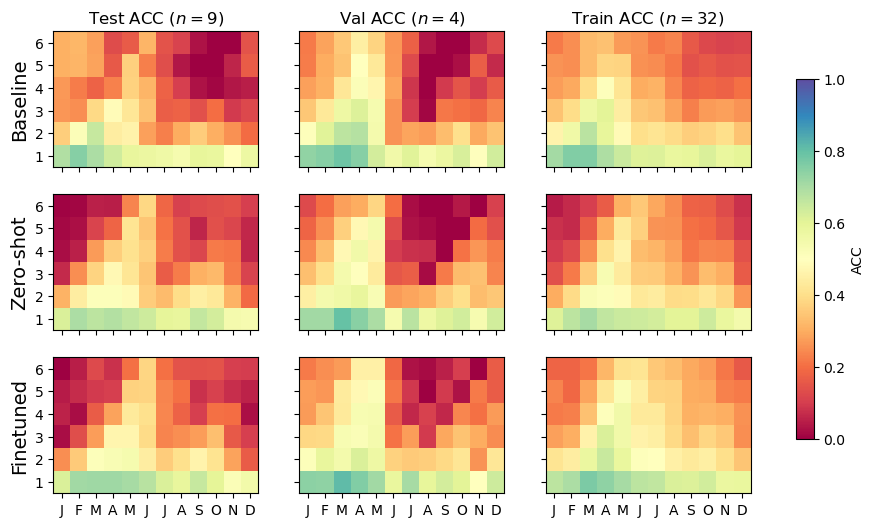

In [89]:
fig, axs = plt.subplots(figsize=(9,6), nrows=3, ncols=3, sharey=True, sharex=True)
x = np.arange(13)
y = np.arange(7)
x_centers = (x[:-1] + x[1:]) / 2
y_centers = (y[:-1] + y[1:]) / 2

cax = axs[0,0].pcolormesh(x, y, test_acc, cmap="Spectral", shading='flat', vmin=0, vmax=1)
axs[1,0].pcolormesh(x, y, test_acc_zs, cmap="Spectral", shading='flat', vmin=0, vmax=1)
axs[2,0].pcolormesh(x, y, test_acc_ft, cmap="Spectral", shading='flat', vmin=0, vmax=1)

axs[0,1].pcolormesh(x, y, val_acc, cmap="Spectral", shading='flat', vmin=0, vmax=1)
axs[1,1].pcolormesh(x, y, val_acc_zs, cmap="Spectral", shading='flat', vmin=0, vmax=1)
axs[2,1].pcolormesh(x, y, val_acc_ft, cmap="Spectral", shading='flat', vmin=0, vmax=1)

axs[0,2].pcolormesh(x, y, train_acc, cmap="Spectral", shading='flat', vmin=0, vmax=1)
axs[1,2].pcolormesh(x, y, train_acc_zs, cmap="Spectral", shading='flat', vmin=0, vmax=1)
axs[2,2].pcolormesh(x, y, train_acc_ft, cmap="Spectral", shading='flat', vmin=0, vmax=1)


label = ["Baseline", "Zero-shot", "Finetuned"]
for i in range(3):
    axs[2,i].set_xticks(x_centers, labels=["J","F","M","A","M","J","J","A","S","O","N","D"])
    axs[i,0].set_yticks(y_centers, labels=np.arange(1, 7, 1))
    axs[i,0].set_ylabel(f"{label[i]}", fontsize=14)

axs[0,0].set_title(r"Test ACC ($n=9$)")
axs[0,1].set_title(r"Val ACC ($n=4$)")
axs[0,2].set_title(r"Train ACC ($n=32$)")

cbar_ax = fig.add_axes([0.95, 0.2, 0.02, 0.6]) 

fig.colorbar(cax, cax=cbar_ax, orientation='vertical', label='ACC')
plt.savefig("figures/cesm/exp3_finetune_acc.jpg", dpi=300, bbox_inches='tight')


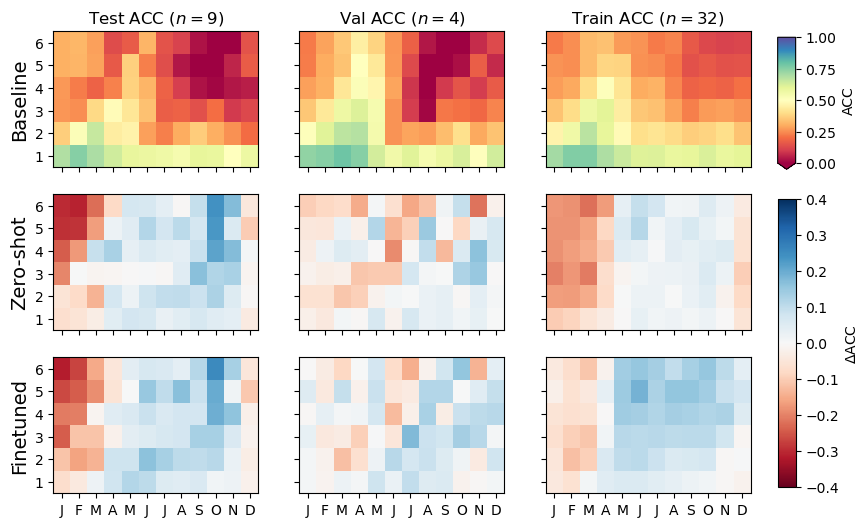

In [21]:
fig, axs = plt.subplots(figsize=(9,6), nrows=3, ncols=3, sharey=True, sharex=True)
x = np.arange(13)
y = np.arange(7)
x_centers = (x[:-1] + x[1:]) / 2
y_centers = (y[:-1] + y[1:]) / 2

cax2 = axs[0,0].pcolormesh(x, y, test_acc, cmap="Spectral", shading='flat', vmin=0, vmax=1)
cax = axs[1,0].pcolormesh(x, y, test_acc_zs - test_acc, cmap="RdBu", shading='flat', vmin=-0.4, vmax=0.4)
axs[2,0].pcolormesh(x, y, test_acc_ft - test_acc, cmap="RdBu", shading='flat', vmin=-0.4, vmax=0.4)

axs[0,1].pcolormesh(x, y, val_acc, cmap="Spectral", shading='flat', vmin=0, vmax=1)
axs[1,1].pcolormesh(x, y, val_acc_zs - val_acc, cmap="RdBu", shading='flat', vmin=-0.4, vmax=0.4)
axs[2,1].pcolormesh(x, y, val_acc_ft - val_acc, cmap="RdBu", shading='flat', vmin=-0.4, vmax=0.4)

axs[0,2].pcolormesh(x, y, train_acc, cmap="Spectral", shading='flat', vmin=0, vmax=1)
axs[1,2].pcolormesh(x, y, train_acc_zs - train_acc, cmap="RdBu", shading='flat', vmin=-0.4, vmax=0.4)
axs[2,2].pcolormesh(x, y, train_acc_ft - train_acc, cmap="RdBu", shading='flat', vmin=-0.4, vmax=0.4)


label = ["Baseline", "Zero-shot", "Finetuned"]
for i in range(3):
    axs[2,i].set_xticks(x_centers, labels=["J","F","M","A","M","J","J","A","S","O","N","D"])
    axs[i,0].set_yticks(y_centers, labels=np.arange(1, 7, 1))
    axs[i,0].set_ylabel(f"{label[i]}", fontsize=14)

axs[0,0].set_title(r"Test ACC ($n=9$)")
axs[0,1].set_title(r"Val ACC ($n=4$)")
axs[0,2].set_title(r"Train ACC ($n=32$)")

cbar_ax = fig.add_axes([0.93, 0.12, 0.02, 0.48]) 
cbar_ax2 = fig.add_axes([0.93, 0.65, 0.02, 0.22]) 

fig.colorbar(cax, cax=cbar_ax, orientation='vertical', label=r'$\Delta$ACC')
fig.colorbar(cax2, cax=cbar_ax2, orientation='vertical', extend='min', label=r'ACC')

plt.savefig("figures/cesm/exp3_finetune_acc_change.jpg", dpi=300, bbox_inches='tight')


In [71]:
def calculate_rmse(predictions, targets):
    max_lead_months = len(predictions.lead_time)
    
    rmse_da = xr.DataArray(
        np.empty((max_lead_months, 12)),
        dims = ("lead_time", "month")
    )

    for lead in range(max_lead_months):
        squared_residuals = (targets.isel(lead_time=lead) - predictions.isel(lead_time=lead)) ** 2

        mse = squared_residuals.groupby("start_prediction_month.month").mean(("start_prediction_month", "x", "y"))
        rmse = np.sqrt(mse)

        rmse_da[lead, :] = np.roll(rmse, lead) 
        
    return rmse_da

test_rmse = calculate_rmse(ds_pred_test.icefrac, ds_truth_test.icefrac)
val_rmse = calculate_rmse(ds_pred_val.icefrac, ds_truth_val.icefrac)
train_rmse = calculate_rmse(ds_pred_train.icefrac, ds_truth_train.icefrac)

test_rmse_ft = calculate_rmse(ds_pred_test_ft.icefrac, ds_truth_test.icefrac)
val_rmse_ft = calculate_rmse(ds_pred_val_ft.icefrac, ds_truth_val.icefrac)
train_rmse_ft = calculate_rmse(ds_pred_train_ft.icefrac, ds_truth_train.icefrac)

test_rmse_zs = calculate_rmse(ds_pred_test_zs.icefrac, ds_truth_test.icefrac)
val_rmse_zs = calculate_rmse(ds_pred_val_zs.icefrac, ds_truth_val.icefrac)
train_rmse_zs = calculate_rmse(ds_pred_train_zs.icefrac, ds_truth_train.icefrac)

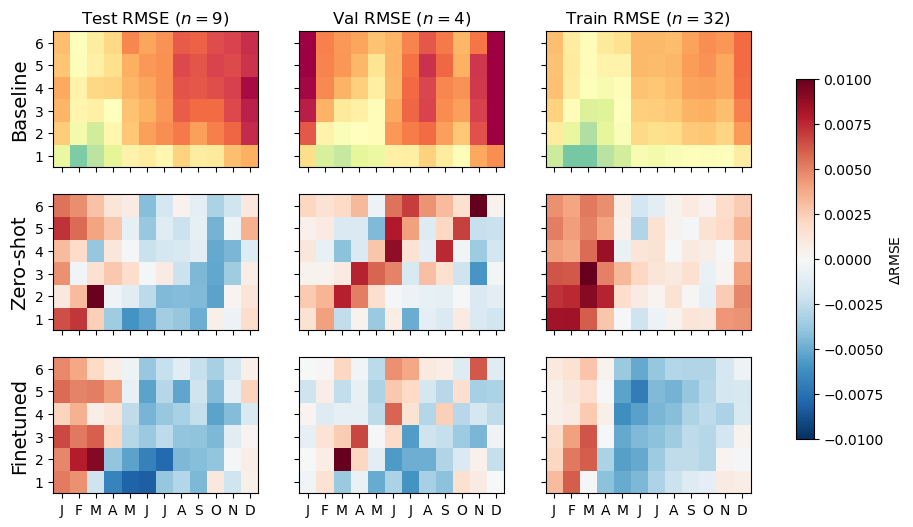

In [91]:
fig, axs = plt.subplots(figsize=(9,6), nrows=3, ncols=3, sharey=True, sharex=True)
x = np.arange(13)
y = np.arange(7)
x_centers = (x[:-1] + x[1:]) / 2
y_centers = (y[:-1] + y[1:]) / 2

axs[0,0].pcolormesh(x, y, test_rmse, cmap="Spectral_r", shading='flat', vmin=0.03, vmax=0.1)
cax = axs[1,0].pcolormesh(x, y, test_rmse_zs - test_rmse, cmap="RdBu_r", shading='flat', vmin=-0.01, vmax=0.01)
axs[2,0].pcolormesh(x, y, test_rmse_ft - test_rmse, cmap="RdBu_r", shading='flat', vmin=-0.01, vmax=0.01)

axs[0,1].pcolormesh(x, y, val_rmse, cmap="Spectral_r", shading='flat', vmin=0.03, vmax=0.1)
axs[1,1].pcolormesh(x, y, val_rmse_zs - val_rmse, cmap="RdBu_r", shading='flat', vmin=-0.01, vmax=0.01)
axs[2,1].pcolormesh(x, y, val_rmse_ft - val_rmse, cmap="RdBu_r", shading='flat', vmin=-0.01, vmax=0.01)

axs[0,2].pcolormesh(x, y, train_rmse, cmap="Spectral_r", shading='flat', vmin=0.03, vmax=0.1)
axs[1,2].pcolormesh(x, y, train_rmse_zs - train_rmse, cmap="RdBu_r", shading='flat', vmin=-0.01, vmax=0.01)
axs[2,2].pcolormesh(x, y, train_rmse_ft - train_rmse, cmap="RdBu_r", shading='flat', vmin=-0.01, vmax=0.01)


label = ["Baseline", "Zero-shot", "Finetuned"]
for i in range(3):
    axs[2,i].set_xticks(x_centers, labels=["J","F","M","A","M","J","J","A","S","O","N","D"])
    axs[i,0].set_yticks(y_centers, labels=np.arange(1, 7, 1))
    axs[i,0].set_ylabel(f"{label[i]}", fontsize=14)

axs[0,0].set_title(r"Test RMSE ($n=9$)")
axs[0,1].set_title(r"Val RMSE ($n=4$)")
axs[0,2].set_title(r"Train RMSE ($n=32$)")

cbar_ax = fig.add_axes([0.95, 0.2, 0.02, 0.6]) 

fig.colorbar(cax, cax=cbar_ax, orientation='vertical', label=r'$\Delta$RMSE')
plt.savefig("figures/cesm/exp3_finetune_rmse_change.jpg", dpi=300, bbox_inches='tight')


In [ ]:
def plot_pred_example(da_pred1, da_pred2, da_truth, start_prediction_month, savepath=None):
    import cartopy.crs as ccrs
    months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
            'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    lon = reference_grid.lon.data
    lat = reference_grid.lat.data

    fig, axs = plt.subplots(figsize=(12, 6), nrows=3, ncols=6, sharex=True, sharey=True, 
                            subplot_kw={'projection': ccrs.SouthPolarStereo()})

    for i in range(6):
        pred1 = da_pred1.isel(start_prediction_month=start_prediction_month, lead_time=i)
        pred2 = da_pred2.isel(start_prediction_month=start_prediction_month, lead_time=i)
        truth = da_truth.isel(start_prediction_month=start_prediction_month, lead_time=i)

        axs[0,i].pcolormesh(lon, lat, pred1, transform=ccrs.PlateCarree(), vmin=-0.5, vmax=0.5, cmap="RdBu_r")
        axs[1,i].pcolormesh(lon, lat, pred2, transform=ccrs.PlateCarree(), vmin=-0.5, vmax=0.5, cmap="RdBu_r")
        axs[2,i].pcolormesh(lon, lat, truth, transform=ccrs.PlateCarree(), vmin=-0.5, vmax=0.5, cmap="RdBu_r")

        # print acc 
        acc_1 =  np.corrcoef(pred1.to_numpy().flatten(), truth.to_numpy().flatten()).round(2)[0,1]
        acc_2 =  np.corrcoef(pred2.to_numpy().flatten(), truth.to_numpy().flatten()).round(2)[0,1]
        axs[0,i].text(25, -60, acc_1, transform=ccrs.PlateCarree())
        axs[1,i].text(25, -60, acc_2, transform=ccrs.PlateCarree())
        axs[0,i].set_title(f"Lead {i+1} ({months[(start_prediction_month + i + 1) % 12]})")
        for j in range(3):
            axs[j,i].coastlines()
            axs[j,0].yaxis.set_visible(True) 
            axs[j,0].set_yticks([])
    axs[0,0].set_ylabel("Finetuned UNet")
    axs[1,0].set_ylabel("Baseline UNet")
    axs[2,0].set_ylabel("Truth")

    start_pred_mon = da_truth.start_prediction_month.isel(start_prediction_month=start_prediction_month)
    plt.suptitle(f"Init month: {start_pred_mon.values.astype('datetime64[M]')}")
    if savepath is not None:
        plt.savefig(savepath, dpi=250, bbox_inches='tight')
    plt.show()

for i in range(len(ds_pred_test_ft.start_prediction_month)):
    plot_pred_example(ds_pred_test_ft.icefrac, ds_pred_test.icefrac, ds_truth_test.icefrac, i,
                    savepath=f"figures/cesm/sample_predictions/exp3_finetune_test_{i}.jpg")

# plot_pred_example(ds_pred_test, ds_truth_test, 65)

## Plot results for model finetuned on CESM climatology
Date: 5/28

### Finetuned model 1 (predict anom relative to cesm)

In [88]:
import src.experiment_configs.exp1_inputs.input2 as config2
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

config2.DATA_CONFIG_NAME = "seaice_plus_auxiliary_cesmclim"

# dataloaders
train_dataset = Obs_Dataset("train", config2.DATA_CONFIG_NAME, data_split_settings)
train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=False, num_workers=0)
val_dataset = Obs_Dataset("val", config2.DATA_CONFIG_NAME, data_split_settings)
val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=0)
test_dataset = Obs_Dataset("test", config2.DATA_CONFIG_NAME, data_split_settings)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=0)

run_id = 'k5qgn2q3'
checkpoint_path = f"/scratch/users/yucli/sicpred_models/exp3_obs_finetune_sweep/seaice_plus_auxiliary_cesmclim_{run_id}_best.pt"
checkpoint = torch.load(checkpoint_path, map_location=device, weights_only=True)

in_channels = util_cesm.get_num_input_channels(config2.INPUT_CONFIG)
out_channels = util_cesm.get_num_output_channels(config2.MAX_LEAD_MONTHS, config2.TARGET_CONFIG)
model = UNetRes3(in_channels=in_channels, 
                out_channels=out_channels, 
                predict_anomalies=config2.TARGET_CONFIG["predict_anom"]).to(device)

model.load_state_dict(checkpoint)

# evaluate on test 
# note that these predictions are anomalies relative to CESM climatology, so we'll want to transform them back
ds_pred_train_ft_1, ds_truth_train_ft_1 = evaluate(model, train_dataloader)
ds_pred_val_ft_1, ds_truth_val_ft_1 = evaluate(model, val_dataloader)
ds_pred_test_ft_1, ds_truth_test_ft_1 = evaluate(model, test_dataloader)

In [90]:
# Now, we want to convert the CESM anomalies to obs anomalies
cesm_clim_dir = "/scratch/users/yucli/cesm_data_processed/normalized_inputs/seaice_plus_auxiliary_vol4_dt"

icefrac_obs = xr.open_dataset(os.path.join(config_cesm.DATA_DIRECTORY, f"ERA5/cesm_format/icefrac_obs.nc")).icefrac 
icefrac_train_subset = icefrac_obs[np.concatenate((np.arange(12, dtype=int), train_subset + int(12)))]
clim_obs = icefrac_train_subset.groupby("time.month").mean("time")
clim_cesm = xr.open_dataset(os.path.join(cesm_clim_dir, "icefrac_mean.nc")).icefrac

cesm_results = [ds_pred_train_ft_1, ds_truth_train_ft_1, ds_pred_val_ft_1, ds_truth_val_ft_1, ds_pred_test_ft_1, ds_truth_test_ft_1]
delta_clim = clim_cesm - clim_obs

for i in range(len(cesm_results)):
    anomalies = cesm_results[i]
    start_month = anomalies["start_prediction_month"].dt.month  
    lead_time = anomalies["lead_time"] 
    target_month = ((start_month + lead_time - 2) % 12) + 1 

    correction = delta_clim.sel(month = target_month)
    cesm_results[i] = anomalies + correction

ds_pred_train_ft_1, ds_truth_train_ft_1, ds_pred_val_ft_1, ds_truth_val_ft_1, ds_pred_test_ft_1, ds_truth_test_ft_1 = cesm_results

In [93]:
test_acc_ft_1 = calculate_acc(ds_pred_test_ft_1.icefrac, ds_truth_test_ft_1.icefrac, dim=("x","y"), aggregate=True)
val_acc_ft_1 = calculate_acc(ds_pred_val_ft_1.icefrac, ds_truth_val_ft_1.icefrac, dim=("x","y"), aggregate=True)
train_acc_ft_1 = calculate_acc(ds_pred_train_ft_1.icefrac, ds_truth_train_ft_1.icefrac, dim=("x","y"), aggregate=True)

### finetuned model 2 (predict anomalies relative to obs)

In [94]:
# model (best = p704qlo1)
run_id = 'p704qlo1'
checkpoint_path = f"/scratch/users/yucli/sicpred_models/exp3_obs_finetune_sweep/seaice_plus_auxiliary_{run_id}_best.pt"
checkpoint = torch.load(checkpoint_path, map_location=device, weights_only=True)

config2.DATA_CONFIG_NAME = "seaice_plus_auxiliary"

train_dataset = Obs_Dataset("train", config2.DATA_CONFIG_NAME, data_split_settings)
train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=False, num_workers=0)
val_dataset = Obs_Dataset("val", config2.DATA_CONFIG_NAME, data_split_settings)
val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=0)
test_dataset = Obs_Dataset("test", config2.DATA_CONFIG_NAME, data_split_settings)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=0)

in_channels = util_cesm.get_num_input_channels(config2.INPUT_CONFIG)
out_channels = util_cesm.get_num_output_channels(config2.MAX_LEAD_MONTHS, config2.TARGET_CONFIG)
model = UNetRes3(in_channels=in_channels, 
                out_channels=out_channels, 
                predict_anomalies=config2.TARGET_CONFIG["predict_anom"]).to(device)

model.load_state_dict(checkpoint)

# evaluate on test 
ds_pred_train_ft_2, truth_train = evaluate(model, train_dataloader)
ds_pred_val_ft_2, truth_val = evaluate(model, val_dataloader)
ds_pred_test_ft_2, truth_test = evaluate(model, test_dataloader)

test_acc_ft_2 = calculate_acc(ds_pred_test_ft_2.icefrac, truth_test.icefrac, dim=("x","y"), aggregate=True)
val_acc_ft_2 = calculate_acc(ds_pred_val_ft_2.icefrac, truth_val.icefrac, dim=("x","y"), aggregate=True)
train_acc_ft_2 = calculate_acc(ds_pred_train_ft_2.icefrac, truth_train.icefrac, dim=("x","y"), aggregate=True)

### baseline model

In [95]:
run_id = 'jbns1cqy'
checkpoint_path = f"/scratch/users/yucli/sicpred_models/exp3_obs_hypsweep/seaice_plus_auxiliary_{run_id}_best.pt"
checkpoint = torch.load(checkpoint_path, map_location=device, weights_only=True)

in_channels = util_cesm.get_num_input_channels(config2.INPUT_CONFIG)
out_channels = util_cesm.get_num_output_channels(config2.MAX_LEAD_MONTHS, config2.TARGET_CONFIG)
model = UNetRes3(in_channels=in_channels, 
                out_channels=out_channels, 
                predict_anomalies=config2.TARGET_CONFIG["predict_anom"]).to(device)

model.load_state_dict(checkpoint)

# evaluate on test 
ds_pred_train, ds_truth_train = evaluate(model, train_dataloader)
ds_pred_val, ds_truth_val = evaluate(model, val_dataloader)
ds_pred_test, ds_truth_test = evaluate(model, test_dataloader)

test_acc = calculate_acc(ds_pred_test.icefrac, ds_truth_test.icefrac, dim=("x","y"), aggregate=True)
val_acc = calculate_acc(ds_pred_val.icefrac, ds_truth_val.icefrac, dim=("x","y"), aggregate=True)
train_acc = calculate_acc(ds_pred_train.icefrac, ds_truth_train.icefrac, dim=("x","y"), aggregate=True)

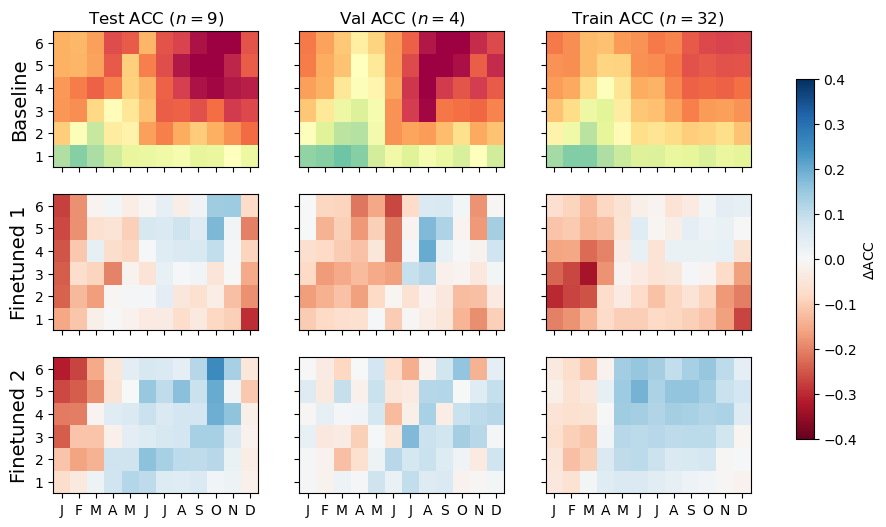

In [106]:
fig, axs = plt.subplots(figsize=(9,6), nrows=3, ncols=3, sharey=True, sharex=True)
x = np.arange(13)
y = np.arange(7)
x_centers = (x[:-1] + x[1:]) / 2
y_centers = (y[:-1] + y[1:]) / 2

axs[0,0].pcolormesh(x, y, test_acc, cmap="Spectral", shading='flat', vmin=0, vmax=1)
cax = axs[1,0].pcolormesh(x, y, test_acc_ft_1 - test_acc, cmap="RdBu", shading='flat', vmin=-0.4, vmax=0.4)
axs[2,0].pcolormesh(x, y, test_acc_ft_2 - test_acc, cmap="RdBu", shading='flat', vmin=-0.4, vmax=0.4)

axs[0,1].pcolormesh(x, y, val_acc, cmap="Spectral", shading='flat', vmin=0, vmax=1)
axs[1,1].pcolormesh(x, y, val_acc_ft_1 - val_acc, cmap="RdBu", shading='flat', vmin=-0.4, vmax=0.4)
axs[2,1].pcolormesh(x, y, val_acc_ft_2 - val_acc, cmap="RdBu", shading='flat', vmin=-0.4, vmax=0.4)

axs[0,2].pcolormesh(x, y, train_acc, cmap="Spectral", shading='flat', vmin=0, vmax=1)
axs[1,2].pcolormesh(x, y, train_acc_ft_1 - train_acc, cmap="RdBu", shading='flat', vmin=-0.4, vmax=0.4)
axs[2,2].pcolormesh(x, y, train_acc_ft_2 - train_acc, cmap="RdBu", shading='flat', vmin=-0.4, vmax=0.4)


label = ["Baseline", "Finetuned 1", "Finetuned 2"]
for i in range(3):
    axs[2,i].set_xticks(x_centers, labels=["J","F","M","A","M","J","J","A","S","O","N","D"])
    axs[i,0].set_yticks(y_centers, labels=np.arange(1, 7, 1))
    axs[i,0].set_ylabel(f"{label[i]}", fontsize=14)

axs[0,0].set_title(r"Test ACC ($n=9$)")
axs[0,1].set_title(r"Val ACC ($n=4$)")
axs[0,2].set_title(r"Train ACC ($n=32$)")

cbar_ax = fig.add_axes([0.95, 0.2, 0.02, 0.6]) 

fig.colorbar(cax, cax=cbar_ax, orientation='vertical', label=r'$\Delta$ACC')
plt.savefig("figures/cesm/exp3_finetune_acc_change_2.jpg", dpi=300, bbox_inches='tight')


In [103]:
def calculate_rmse(predictions, targets):
    max_lead_months = len(predictions.lead_time)
    
    rmse_da = xr.DataArray(
        np.empty((max_lead_months, 12)),
        dims = ("lead_time", "month")
    )

    for lead in range(max_lead_months):
        squared_residuals = (targets.isel(lead_time=lead) - predictions.isel(lead_time=lead)) ** 2

        mse = squared_residuals.groupby("start_prediction_month.month").mean(("start_prediction_month", "x", "y"))
        rmse = np.sqrt(mse)

        rmse_da[lead, :] = np.roll(rmse, lead) 
        
    return rmse_da

test_rmse = calculate_rmse(ds_pred_test.icefrac, ds_truth_test.icefrac)
val_rmse = calculate_rmse(ds_pred_val.icefrac, ds_truth_val.icefrac)
train_rmse = calculate_rmse(ds_pred_train.icefrac, ds_truth_train.icefrac)

test_rmse_ft_1 = calculate_rmse(ds_pred_test_ft_1.icefrac, ds_truth_test_ft_1.icefrac)
val_rmse_ft_1 = calculate_rmse(ds_pred_val_ft_1.icefrac, ds_truth_val_ft_1.icefrac)
train_rmse_ft_1 = calculate_rmse(ds_pred_train_ft_1.icefrac, ds_truth_train_ft_1.icefrac)

test_rmse_ft_2 = calculate_rmse(ds_pred_test_ft_2.icefrac, ds_truth_test_ft_1.icefrac)
val_rmse_ft_2 = calculate_rmse(ds_pred_val_ft_2.icefrac, ds_truth_val_ft_1.icefrac)
train_rmse_ft_2 = calculate_rmse(ds_pred_train_ft_2.icefrac, ds_truth_train_ft_1.icefrac)

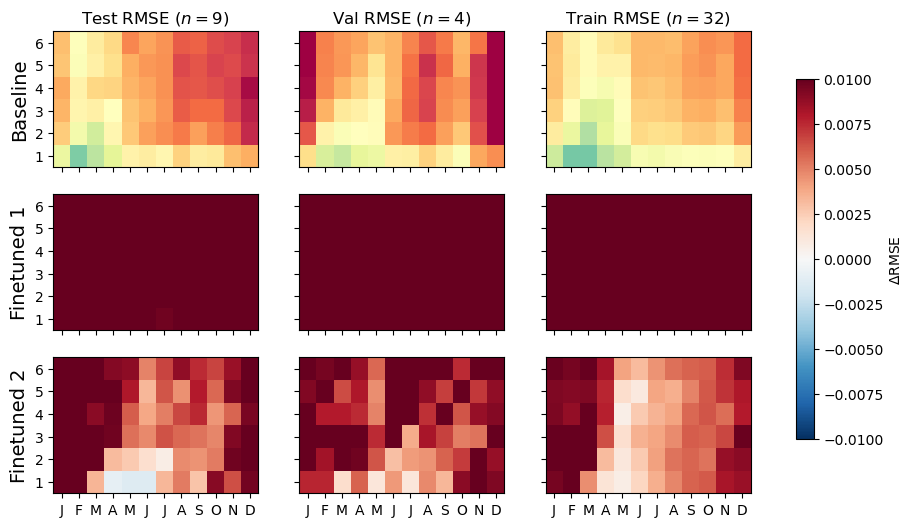

In [105]:
fig, axs = plt.subplots(figsize=(9,6), nrows=3, ncols=3, sharey=True, sharex=True)
x = np.arange(13)
y = np.arange(7)
x_centers = (x[:-1] + x[1:]) / 2
y_centers = (y[:-1] + y[1:]) / 2

axs[0,0].pcolormesh(x, y, test_rmse, cmap="Spectral_r", shading='flat', vmin=0.03, vmax=0.1)
cax = axs[1,0].pcolormesh(x, y, test_rmse_ft_1 - test_rmse, cmap="RdBu_r", shading='flat', vmin=-0.01, vmax=0.01)
axs[2,0].pcolormesh(x, y, test_rmse_ft_2 - test_rmse, cmap="RdBu_r", shading='flat', vmin=-0.01, vmax=0.01)

axs[0,1].pcolormesh(x, y, val_rmse, cmap="Spectral_r", shading='flat', vmin=0.03, vmax=0.1)
axs[1,1].pcolormesh(x, y, val_rmse_ft_1 - val_rmse, cmap="RdBu_r", shading='flat', vmin=-0.01, vmax=0.01)
axs[2,1].pcolormesh(x, y, val_rmse_ft_2 - val_rmse, cmap="RdBu_r", shading='flat', vmin=-0.01, vmax=0.01)

axs[0,2].pcolormesh(x, y, train_rmse, cmap="Spectral_r", shading='flat', vmin=0.03, vmax=0.1)
axs[1,2].pcolormesh(x, y, train_rmse_ft_1 - train_rmse, cmap="RdBu_r", shading='flat', vmin=-0.01, vmax=0.01)
axs[2,2].pcolormesh(x, y, train_rmse_ft_2 - train_rmse, cmap="RdBu_r", shading='flat', vmin=-0.01, vmax=0.01)


label = ["Baseline", "Finetuned 1", "Finetuned 2"]
for i in range(3):
    axs[2,i].set_xticks(x_centers, labels=["J","F","M","A","M","J","J","A","S","O","N","D"])
    axs[i,0].set_yticks(y_centers, labels=np.arange(1, 7, 1))
    axs[i,0].set_ylabel(f"{label[i]}", fontsize=14)

axs[0,0].set_title(r"Test RMSE ($n=9$)")
axs[0,1].set_title(r"Val RMSE ($n=4$)")
axs[0,2].set_title(r"Train RMSE ($n=32$)")

cbar_ax = fig.add_axes([0.95, 0.2, 0.02, 0.6]) 

fig.colorbar(cax, cax=cbar_ax, orientation='vertical', label=r'$\Delta$RMSE')
#plt.savefig("figures/cesm/exp3_finetune_rmse_change.jpg", dpi=300, bbox_inches='tight')


## Sweep 3 (input4)

In [ ]:
import src.experiment_configs.exp1_inputs.input4 as config4
import src.experiment_configs.exp1_inputs.input2 as config2

data_config = config4

sweep_config = {
    'method': 'random', 
    'metric': {
        'name': 'best_val_rmse',
        'goal': 'minimize'
    },
    'parameters': {
        'lr': {
            'min': 1e-5,
            'max': 2e-3 
        },
        'weight_decay': {
            'min': 0.0,
            'max': 1e-4
        },
        'batch_size': {
            'values': [20, 32, 50, 64] 
        },
        'n_channels_factor': {
            'values': [0.5, 0.75, 1]
        },
        'num_epochs': {
            'value': 100
        },
        'loss_function_args': {
            'value': 1
        }
    }
}

sweep_id = wandb.sweep(sweep_config, project="sea-ice-prediction")

save_path = "/scratch/users/yucli/sicpred_models/exp3_obs_hypsweep"
wandb.agent(sweep_id, function=lambda: train(data_config, save_path=save_path), count=50)


## Finetune 

In [48]:
import src.experiment_configs.exp1_inputs.input2 as config2

data_config = config2
data_config.DATA_CONFIG_NAME = "seaice_plus_auxiliary_cesmclim"

sweep_config = {
    'method': 'random', 
    'metric': {
        'name': 'best_val_rmse',
        'goal': 'minimize'
    },
    'parameters': {
        'lr': {
            'min': 1e-5,
            'max': 5e-3 
        },
        'weight_decay': {
            'value': 0
        },
        'batch_size': {
            'values': [20, 32, 50, 64] 
        },
        'num_epochs': {
            'value': 100
        },
        'loss_function_args': {
            'value': 1
        }
    }
}

# load the pretrained model
checkpoint_path = "/scratch/users/yucli/sicpred_models/exp2_vol4_dt/UNetRes3_exp2_vol4_dt_member_0_epoch_10.pth"

sweep_id = wandb.sweep(sweep_config, project="sea-ice-prediction")
save_path = "/scratch/users/yucli/sicpred_models/exp3_obs_finetune_sweep"
os.makedirs(save_path, exist_ok=True)
wandb.agent(sweep_id, function=lambda: train(data_config, save_path=save_path,
            architecture=None, finetune_model_path=checkpoint_path), count=50)


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


Create sweep with ID: ig2sril5
Sweep URL: https://wandb.ai/ychnli-stanford-university/sea-ice-prediction/sweeps/ig2sril5


wandb: Agent Starting Run: j5az2cd7 with config:
wandb: 	batch_size: 50
wandb: 	loss_function_args: 1
wandb: 	lr: 0.0004849810617328947
wandb: 	num_epochs: 100
wandb: 	weight_decay: 0
wandb: Currently logged in as: ychnli (ychnli-stanford-university). Use `wandb login --relogin` to force relogin


Epoch 13/100 [Val]: 100%|██████████| 2/2 [00:00<00:00,  8.74it/s, Batch RMSE=0.0875]


Early stopping triggered at epoch 14


best_val_rmse,█▅▃▂▂▁▁▁▁▁▁▁▁
epoch,▁▂▂▃▃▄▄▅▅▆▆▇▇█
epoch_train_loss,█▅▄▄▃▃▃▂▂▂▂▁▁▁
epoch_val_loss,█▄▃▂▁▁▁▁▁▁▂▂▂▂
epoch_val_rmse,█▅▃▂▂▁▁▁▁▁▁▁▁▁
lr,████▇▇▆▆▅▅▄▃▂▁
train_loss,██▆▅▆▅▄▄▄▄▄▃▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
val_loss,▄█▃▆▂▅▂▄▁▄▁▃▁▃▁▄▁▄▁▄▁▄▁▄▁▄▁▅
val_rmse,█▇▆▄▄▃▃▁▃▁▂▁▂▁▂▁▂▁▂▂▂▂▂▂▂▂▂▃
best_val_rmse,0.0842
epoch,13


wandb: Agent Starting Run: k5qgn2q3 with config:
wandb: 	batch_size: 50
wandb: 	loss_function_args: 1
wandb: 	lr: 0.0031805629906012218
wandb: 	num_epochs: 100
wandb: 	weight_decay: 0


Epoch 9/100 [Val]: 100%|██████████| 2/2 [00:00<00:00,  8.96it/s, Batch RMSE=0.0875]


Early stopping triggered at epoch 10


best_val_rmse,█▄▂▂▁▁▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█
epoch_train_loss,█▅▄▃▃▂▂▁▁▁
epoch_val_loss,█▄▁▁▁▁▄▃▃▄
epoch_val_rmse,█▄▂▂▁▁▂▁▂▂
lr,███▇▇▆▅▄▂▁
train_loss,█▆▆▆▅▅▄▄▅▄▄▄▄▃▃▃▃▂▂▃▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁
val_loss,▄█▂▇▂▆▁▆▁▆▁▆▁█▁▇▁▇▂▇
val_rmse,█▅▄▃▂▂▂▃▁▃▁▃▂▅▁▄▂▄▂▄
best_val_rmse,0.08298
epoch,9


wandb: Agent Starting Run: ymgvvfce with config:
wandb: 	batch_size: 50
wandb: 	loss_function_args: 1
wandb: 	lr: 0.004934435818680432
wandb: 	num_epochs: 100
wandb: 	weight_decay: 0


Epoch 14/100 [Val]: 100%|██████████| 2/2 [00:00<00:00,  9.87it/s, Batch RMSE=0.0852]


Early stopping triggered at epoch 15


best_val_rmse,█▆▃▂▂▂▂▂▂▁▁▁▁▁
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
epoch_train_loss,█▅▄▄▃▃▂▂▂▂▂▁▁▁▁
epoch_val_loss,██▄▃▄▆▃▃▄▁▂▃▂▂▂
epoch_val_rmse,█▆▃▂▂▃▂▃▂▁▂▂▂▁▂
lr,████▇▇▇▆▆▅▄▄▃▂▁
train_loss,█▇▇▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁
val_loss,▄▇▃█▂▆▂▅▁▆▂█▁▅▂▅▁▆▁▄▁▅▁▅▁▅▁▅▂▅
val_rmse,█▆▆▆▄▄▃▃▂▄▃█▂▂▄▃▂▄▁▁▂▂▂▃▂▂▁▃▂▂
best_val_rmse,0.08401
epoch,14


wandb: Agent Starting Run: ipmfb7s8 with config:
wandb: 	batch_size: 50
wandb: 	loss_function_args: 1
wandb: 	lr: 0.002537022582424797
wandb: 	num_epochs: 100
wandb: 	weight_decay: 0


Epoch 12/100 [Val]: 100%|██████████| 2/2 [00:00<00:00,  9.82it/s, Batch RMSE=0.09]  


Early stopping triggered at epoch 13


best_val_rmse,█▄▂▁▁▁▁▁▁▁▁▁
epoch,▁▂▂▃▃▄▅▅▆▆▇▇█
epoch_train_loss,█▆▄▄▃▃▂▂▂▂▁▁▁
epoch_val_loss,█▄▂▁▅▂▄▃▃▂▃▄█
epoch_val_rmse,█▄▂▁▂▁▂▁▂▂▂▂▄
lr,████▇▇▆▆▅▄▃▂▁
train_loss,█▆▆▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▂▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▃▇▂▆▁▅▁▅▁▇▁▆▁▇▁▆▁▆▁▆▁▆▁▆▂█
val_rmse,█▅▅▃▃▂▂▁▃▅▂▃▂▄▂▃▂▄▂▃▂▄▃▄▄▇
best_val_rmse,0.08352
epoch,12


wandb: Agent Starting Run: hn2x8jqq with config:
wandb: 	batch_size: 20
wandb: 	loss_function_args: 1
wandb: 	lr: 0.0031188575455158973
wandb: 	num_epochs: 100
wandb: 	weight_decay: 0


Epoch 11/100 [Val]: 100%|██████████| 3/3 [00:00<00:00, 14.07it/s, Batch RMSE=0.0845]


Early stopping triggered at epoch 12


best_val_rmse,█▃▂▁▁▁▁▁▁▁▁
epoch,▁▂▂▃▄▄▅▅▆▇▇█
epoch_train_loss,█▅▄▄▃▃▂▂▂▁▁▁
epoch_val_loss,█▂▁▂▃▆▁▃▃▂▄▅
epoch_val_rmse,█▃▂▁▂▄▁▃▃▂▃▅
lr,███▇▇▇▆▅▄▃▂▁
train_loss,█▆▄▄▃▄▃▃▃▃▃▃▃▄▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
val_loss,▇▄▅▅▃▃▅▁▃▅▂▃▆▃▃█▂▄▇▁▂▆▂▃▇▂▃▆▂▂▇▂▃▇▂▄
val_rmse,█▇▄▆▅▂▆▃▃▆▃▃▆▄▂█▃▃▇▃▁▇▄▃▇▃▂▇▄▂▇▄▃▇▄▄
best_val_rmse,0.08411
epoch,11


wandb: Agent Starting Run: 84gf7rl7 with config:
wandb: 	batch_size: 20
wandb: 	loss_function_args: 1
wandb: 	lr: 0.0004054230010205445
wandb: 	num_epochs: 100
wandb: 	weight_decay: 0


Epoch 9/100 [Val]: 100%|██████████| 3/3 [00:00<00:00, 13.01it/s, Batch RMSE=0.0822]


Early stopping triggered at epoch 10


best_val_rmse,█▄▂▁▁▁▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█
epoch_train_loss,█▅▄▃▃▂▂▂▁▁
epoch_val_loss,█▄▂▁▁▁▂▂▂▂
epoch_val_rmse,█▄▂▁▁▁▂▂▂▂
lr,███▇▇▆▅▄▂▁
train_loss,█▆▅▅▅▄▃▄▄▄▂▃▃▃▂▂▂▂▂▂▂▂▁▂▂▂▁▂▁▂▁▂▂▁▁▁▁▁▁▁
val_loss,█▆▆▆▃▃▄▂▂▄▁▂▄▁▂▃▂▂▄▂▃▄▂▃▃▂▃▃▂▃
val_rmse,█▇▄▆▄▂▅▃▁▄▃▁▄▂▁▃▃▂▃▃▂▃▃▂▃▄▂▃▃▂
best_val_rmse,0.08375
epoch,9


wandb: Agent Starting Run: 7jnlt0kl with config:
wandb: 	batch_size: 50
wandb: 	loss_function_args: 1
wandb: 	lr: 0.002337736464171848
wandb: 	num_epochs: 100
wandb: 	weight_decay: 0


Epoch 11/100 [Val]: 100%|██████████| 2/2 [00:00<00:00,  9.42it/s, Batch RMSE=0.0837]


Early stopping triggered at epoch 12


best_val_rmse,█▄▂▁▁▁▁▁▁▁▁
epoch,▁▂▂▃▄▄▅▅▆▇▇█
epoch_train_loss,█▅▄▄▃▃▂▂▂▁▁▁
epoch_val_loss,█▃▁▂▂▃▃▄▄▅▁▂
epoch_val_rmse,█▄▂▁▁▁▁▂▂▄▂▂
lr,███▇▇▇▆▅▄▃▂▁
train_loss,█▇▆▅▅▄▄▄▃▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
val_loss,▄█▂▆▁▅▁▆▁▆▁▇▁▇▂▇▁█▂█▁▆▁▆
val_rmse,█▅▄▂▃▁▂▂▃▃▂▃▂▃▃▄▃▅▄▅▃▃▃▂
best_val_rmse,0.08358
epoch,11


wandb: Agent Starting Run: eyvnqeas with config:
wandb: 	batch_size: 20
wandb: 	loss_function_args: 1
wandb: 	lr: 0.004781692553789131
wandb: 	num_epochs: 100
wandb: 	weight_decay: 0


Epoch 10/100 [Val]: 100%|██████████| 3/3 [00:00<00:00, 13.15it/s, Batch RMSE=0.083] 


Early stopping triggered at epoch 11


best_val_rmse,█▄▂▂▂▁▁▁▁▁
epoch,▁▂▂▃▄▅▅▆▇▇█
epoch_train_loss,█▅▄▃▃▂▂▂▁▁▁
epoch_val_loss,█▄▁▄▄▁▃▂▂▂▂
epoch_val_rmse,█▄▂▄▃▁▃▂▃▂▂
lr,███▇▇▆▅▅▄▂▁
train_loss,█▅▅▅▄▃▃▃▃▃▃▂▃▃▃▃▃▂▂▃▂▂▂▂▂▂▂▂▂▁▂▂▁▂▁▁▁▁▁▁
val_loss,█▅▆▆▂▃▄▂▂▅▃▅▇▂▄▅▁▂▆▁▄▅▂▃▅▂▃▅▂▂▆▂▂
val_rmse,█▇▄▆▄▃▄▄▁▅▅▄▆▃▂▄▃▁▆▃▃▄▃▂▅▄▂▄▃▁▅▄▂
best_val_rmse,0.08495
epoch,10


wandb: Agent Starting Run: hs36ctdn with config:
wandb: 	batch_size: 32
wandb: 	loss_function_args: 1
wandb: 	lr: 0.0035138000264707332
wandb: 	num_epochs: 100
wandb: 	weight_decay: 0


Epoch 10/100 [Val]: 100%|██████████| 2/2 [00:00<00:00,  9.71it/s, Batch RMSE=0.0849]


Early stopping triggered at epoch 11


best_val_rmse,█▂▁▁▁▁▁▁▁▁
epoch,▁▂▂▃▄▅▅▆▇▇█
epoch_train_loss,█▅▄▃▃▂▂▂▁▁▁
epoch_val_loss,█▂▁▂▃▂▂▂▃▆▄
epoch_val_rmse,█▂▁▂▃▁▂▂▂▄▃
lr,███▇▇▆▅▅▄▂▁
train_loss,█▆▆▅▄▄▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▄▁▃▁▄▁▄▃▄▁▄▁▄▁▅▂▅▄▅▂
val_rmse,█▅▄▁▂▁▃▁▃▃▂▁▃▂▃▂▃▁▄▅▄▂
best_val_rmse,0.08444
epoch,10


wandb: Agent Starting Run: xczlgyq3 with config:
wandb: 	batch_size: 32
wandb: 	loss_function_args: 1
wandb: 	lr: 0.0023443701589014876
wandb: 	num_epochs: 100
wandb: 	weight_decay: 0


Epoch 9/100 [Val]: 100%|██████████| 2/2 [00:00<00:00, 16.01it/s, Batch RMSE=0.0829]


Early stopping triggered at epoch 10


best_val_rmse,█▃▂▂▁▁▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█
epoch_train_loss,█▅▄▃▃▂▂▂▁▁
epoch_val_loss,█▂▂▁▁▄▃▁▂▂
epoch_val_rmse,█▃▂▂▁▃▃▂▂▂
lr,███▇▇▆▅▄▂▁
train_loss,█▇▇▆▄▄▄▄▃▄▄▃▃▃▄▃▃▂▂▂▂▂▃▂▂▂▂▂▂▂▂▁▂▂▂▁▁▁▁▁
val_loss,█▄▄▂▄▂▃▂▄▂▄▄▅▂▅▁▅▂▅▁
val_rmse,█▅▄▂▃▂▂▃▂▂▃▄▃▃▃▁▃▂▃▂
best_val_rmse,0.08341
epoch,9


wandb: Agent Starting Run: wwle78t5 with config:
wandb: 	batch_size: 20
wandb: 	loss_function_args: 1
wandb: 	lr: 0.0018420184587053224
wandb: 	num_epochs: 100
wandb: 	weight_decay: 0


Epoch 7/100 [Val]: 100%|██████████| 3/3 [00:00<00:00, 14.47it/s, Batch RMSE=0.0841]


Early stopping triggered at epoch 8


best_val_rmse,█▂▁▁▁▁▁
epoch,▁▂▃▄▅▆▇█
epoch_train_loss,█▅▄▃▂▂▁▁
epoch_val_loss,█▂▁▅▃▄▅▆
epoch_val_rmse,█▂▁▃▂▂▅▄
lr,██▇▇▆▄▃▁
train_loss,█▇▅▅▅▅▃▄▅▄▃▄▄▄▃▂▃▄▄▂▂▃▃▂▂▁▂▁▁▂▂▁▁▂▂▁▁▁▂▁
val_loss,█▃▃▅▁▂▄▁▂▇▁▄▆▁▃▆▂▃▆▃▃▅▃▅
val_rmse,█▅▂▅▃▁▄▃▂▅▃▂▅▃▂▅▃▂▅▄▃▅▄▃
best_val_rmse,0.08344
epoch,7


wandb: Agent Starting Run: ryns3ln2 with config:
wandb: 	batch_size: 20
wandb: 	loss_function_args: 1
wandb: 	lr: 0.0017434945611886803
wandb: 	num_epochs: 100
wandb: 	weight_decay: 0


Epoch 10/100 [Val]: 100%|██████████| 3/3 [00:00<00:00, 12.31it/s, Batch RMSE=0.0845]


Early stopping triggered at epoch 11


best_val_rmse,█▂▂▁▁▁▁▁▁▁
epoch,▁▂▂▃▄▅▅▆▇▇█
epoch_train_loss,█▅▄▄▃▂▂▂▂▁▁
epoch_val_loss,█▂▂▁▂▁▃▃▄▅▆
epoch_val_rmse,█▂▂▁▁▁▂▂▄▄▅
lr,███▇▇▆▅▅▄▂▁
train_loss,█▅▅▅▅▅▄▄▄▃▃▃▃▂▃▃▂▃▃▂▂▂▂▂▂▂▂▁▂▂▁▁▁▁▂▂▁▁▁▁
val_loss,█▄▄▄▂▃▄▂▃▄▂▂▅▂▃▅▁▂▆▂▂▆▂▂▇▂▃▇▂▃█▂▄
val_rmse,█▆▂▅▄▂▄▄▂▄▃▂▄▃▁▅▃▁▅▄▂▅▃▁▆▄▂▆▄▃▇▄▄
best_val_rmse,0.08354
epoch,10


wandb: Agent Starting Run: k48p3eqp with config:
wandb: 	batch_size: 50
wandb: 	loss_function_args: 1
wandb: 	lr: 0.004903054147604264
wandb: 	num_epochs: 100
wandb: 	weight_decay: 0


Epoch 11/100 [Val]: 100%|██████████| 2/2 [00:00<00:00,  9.43it/s, Batch RMSE=0.0878]


Early stopping triggered at epoch 12


best_val_rmse,█▅▃▂▁▁▁▁▁▁▁
epoch,▁▂▂▃▄▄▅▅▆▇▇█
epoch_train_loss,█▅▄▃▃▂▂▂▂▁▁▁
epoch_val_loss,█▅▄▃▂▁▁▂▂▂▂▂
epoch_val_rmse,█▅▃▂▁▁▁▁▁▂▂▂
lr,███▇▇▇▆▅▄▃▂▁
train_loss,███▇▅▅▅▄▄▄▃▃▃▃▃▃▂▂▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
val_loss,▅█▃▇▂▆▂▅▁▄▁▄▁▄▁▅▁▄▁▅▂▅▁▅
val_rmse,█▆▅▄▃▃▂▃▂▁▁▂▁▁▁▃▁▂▂▂▂▃▁▂
best_val_rmse,0.08408
epoch,11


wandb: Agent Starting Run: ibt54oeq with config:
wandb: 	batch_size: 64
wandb: 	loss_function_args: 1
wandb: 	lr: 0.0006800394535628711
wandb: 	num_epochs: 100
wandb: 	weight_decay: 0


Epoch 13/100 [Val]: 100%|██████████| 1/1 [00:00<00:00,  5.07it/s, Batch RMSE=0.0846]


Early stopping triggered at epoch 14


best_val_rmse,█▅▃▃▂▁▁▁▁▁▁▁▁
epoch,▁▂▂▃▃▄▄▅▅▆▆▇▇█
epoch_train_loss,█▅▅▄▃▃▃▂▂▂▂▁▁▁
epoch_val_loss,█▅▃▂▂▁▁▁▁▁▁▁▁▁
epoch_val_rmse,█▅▃▃▂▁▁▁▁▁▁▁▁▁
lr,████▇▇▆▆▅▅▄▃▂▁
train_loss,█▇▄▅▅▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▁▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▃▂▂▁▁▁▁▁▁▁▁▁
val_rmse,█▅▃▃▂▁▁▁▁▁▁▁▁▁
best_val_rmse,0.08407
epoch,13


wandb: Agent Starting Run: 30riox7x with config:
wandb: 	batch_size: 64
wandb: 	loss_function_args: 1
wandb: 	lr: 0.0038794852492487607
wandb: 	num_epochs: 100
wandb: 	weight_decay: 0


Epoch 10/100 [Val]: 100%|██████████| 1/1 [00:00<00:00,  4.78it/s, Batch RMSE=0.0847]


Early stopping triggered at epoch 11


best_val_rmse,█▅▃▂▂▁▁▁▁▁
epoch,▁▂▂▃▄▅▅▆▇▇█
epoch_train_loss,█▅▄▃▃▂▂▂▁▁▁
epoch_val_loss,█▄▂▂▁▁▂▁▂▁▁
epoch_val_rmse,█▅▃▂▂▁▂▁▂▁▁
lr,███▇▇▆▅▅▄▂▁
train_loss,█▆▆▅▅▄▄▄▄▄▃▃▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁
val_loss,█▄▂▂▁▁▂▁▂▁▁
val_rmse,█▅▃▂▂▁▂▁▂▁▁
best_val_rmse,0.08427
epoch,10


wandb: Agent Starting Run: rr8rvfvn with config:
wandb: 	batch_size: 50
wandb: 	loss_function_args: 1
wandb: 	lr: 0.0028768799700376116
wandb: 	num_epochs: 100
wandb: 	weight_decay: 0


Epoch 13/100 [Val]: 100%|██████████| 2/2 [00:00<00:00,  9.72it/s, Batch RMSE=0.0901]


Early stopping triggered at epoch 14


best_val_rmse,█▄▃▁▁▁▁▁▁▁▁▁▁
epoch,▁▂▂▃▃▄▄▅▅▆▆▇▇█
epoch_train_loss,█▆▅▄▃▃▃▂▂▂▂▁▁▁
epoch_val_loss,█▃▃▁▃▄▃▃▂▄▄▃▅▇
epoch_val_rmse,█▄▃▁▃▃▂▂▁▃▂▂▃▄
lr,████▇▇▆▆▅▅▄▃▂▁
train_loss,█▆▆▅▄▄▄▄▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁
val_loss,▄█▂▆▂▆▁▅▂▆▂▆▁▆▁▆▁▅▂▇▂▇▁▆▂▇▂█
val_rmse,█▆▅▃▃▃▂▁▃▃▃▃▂▄▂▄▂▁▃▄▃▄▃▃▄▄▄▆
best_val_rmse,0.08345
epoch,13


wandb: Agent Starting Run: li93b6px with config:
wandb: 	batch_size: 50
wandb: 	loss_function_args: 1
wandb: 	lr: 5.260122422788594e-05
wandb: 	num_epochs: 100
wandb: 	weight_decay: 0


Epoch 76/100 [Val]: 100%|██████████| 2/2 [00:00<00:00,  9.51it/s, Batch RMSE=0.0839]


Early stopping triggered at epoch 77


best_val_rmse,█▇▆▅▄▄▄▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇██
epoch_train_loss,█▇▆▅▅▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch_val_loss,█▆▅▄▄▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch_val_rmse,█▇▆▅▅▄▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr,█████▇▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▄▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁
train_loss,██▇▇▆▅▃▄▄▃▄▃▃▃▂▂▂▃▂▂▂▂▂▂▂▂▂▂▂▁▂▁▂▁▁▁▂▂▁▁
val_loss,▅▄█▃▇▆▆▅▂▅▄▄▂▄▂▄▁▁▃▃▃▃▁▁▃▁▃▁▁▁▁▃▃▃▃▁▃▁▃▃
val_rmse,██▆▅▄▂▃▂▂▂▁▁▁▂▁▁▂▁▁▁▂▂▂▂▂▁▁▂▂▂▁▁▁▂▁▂▁▂▁▁
best_val_rmse,0.08549
epoch,76


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: pxc7g6ug with config:
wandb: 	batch_size: 50
wandb: 	loss_function_args: 1
wandb: 	lr: 0.0002160492388051257
wandb: 	num_epochs: 100
wandb: 	weight_decay: 0


Epoch 18/100 [Val]: 100%|██████████| 2/2 [00:00<00:00,  9.87it/s, Batch RMSE=0.0848]


Early stopping triggered at epoch 19


best_val_rmse,█▆▅▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁
epoch,▁▁▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇██
epoch_train_loss,█▆▅▄▄▃▃▃▃▂▂▂▂▂▂▁▁▁▁
epoch_val_loss,█▆▄▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁
epoch_val_rmse,█▆▅▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁
lr,█████▇▇▇▇▆▆▅▅▄▄▃▂▂▁
train_loss,█▆▅▆▆▅▅▄▃▄▃▃▃▃▃▃▂▃▂▂▂▂▂▂▂▁▂▁▂▂▁▂▂▁▁▂▁▁▁▁
val_loss,▄█▃▇▃▅▂▅▂▄▂▄▁▃▁▃▁▃▁▃▁▃▁▃▁▃▁▃▁▃▁▃▁▃▁▃▁▃
val_rmse,██▆▆▅▄▄▃▄▃▃▂▃▂▃▁▂▁▂▁▂▁▂▁▂▁▂▁▂▁▂▁▂▁▂▂▂▂
best_val_rmse,0.0849
epoch,18


wandb: Agent Starting Run: qfe59atd with config:
wandb: 	batch_size: 20
wandb: 	loss_function_args: 1
wandb: 	lr: 0.000339650899463235
wandb: 	num_epochs: 100
wandb: 	weight_decay: 0


Epoch 10/100 [Val]: 100%|██████████| 3/3 [00:00<00:00, 14.29it/s, Batch RMSE=0.0831]


Early stopping triggered at epoch 11


best_val_rmse,█▄▂▂▁▁▁▁▁▁
epoch,▁▂▂▃▄▅▅▆▇▇█
epoch_train_loss,█▅▄▃▃▂▂▂▁▁▁
epoch_val_loss,█▄▂▁▁▁▁▂▂▂▂
epoch_val_rmse,█▄▂▂▁▁▁▁▂▁▂
lr,███▇▇▆▅▅▄▂▁
train_loss,█▅▅▆▅▄▃▃▄▃▃▃▃▂▂▃▃▂▂▂▂▃▂▂▁▁▂▁▂▁▁▁▂▁▁▁▁▁▁▁
val_loss,█▆▆▅▃▃▄▂▂▃▂▂▃▁▂▃▁▂▃▁▂▃▂▂▃▂▃▄▁▃▄▂▃
val_rmse,█▇▅▅▅▂▅▃▁▃▃▁▃▂▁▃▂▁▃▃▁▂▃▂▃▃▂▃▃▂▃▃▂
best_val_rmse,0.08406
epoch,10


wandb: Agent Starting Run: 4zbf59gt with config:
wandb: 	batch_size: 50
wandb: 	loss_function_args: 1
wandb: 	lr: 0.0019406678590650752
wandb: 	num_epochs: 100
wandb: 	weight_decay: 0


Epoch 10/100 [Val]: 100%|██████████| 2/2 [00:00<00:00,  9.23it/s, Batch RMSE=0.0881]


Early stopping triggered at epoch 11


best_val_rmse,█▄▃▁▁▁▁▁▁▁
epoch,▁▂▂▃▄▅▅▆▇▇█
epoch_train_loss,█▅▄▄▃▂▂▂▁▁▁
epoch_val_loss,█▂▃▁▂▂▅▄▃▅▅
epoch_val_rmse,█▄▃▁▁▁▂▃▂▂▃
lr,███▇▇▆▅▅▄▂▁
train_loss,█▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▁▁▁▂▁▁▁▁▁▁▁
val_loss,▄█▂▅▂▆▁▆▁▆▁▆▁█▂▇▁▆▂▇▂█
val_rmse,█▅▅▁▃▂▂▂▂▂▂▂▂▅▃▅▃▃▃▅▄▆
best_val_rmse,0.08359
epoch,10


wandb: Agent Starting Run: 68fb2dwk with config:
wandb: 	batch_size: 64
wandb: 	loss_function_args: 1
wandb: 	lr: 0.0011204868929255657
wandb: 	num_epochs: 100
wandb: 	weight_decay: 0


Epoch 16/100 [Val]: 100%|██████████| 1/1 [00:00<00:00,  4.73it/s, Batch RMSE=0.0856]


Early stopping triggered at epoch 17


best_val_rmse,█▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▂▂▃▃▄▄▅▅▅▆▆▇▇██
epoch_train_loss,█▆▅▄▄▃▃▃▂▂▂▂▂▁▁▁▁
epoch_val_loss,█▄▃▂▁▁▁▁▁▁▁▁▂▂▂▂▂
epoch_val_rmse,█▄▃▂▂▁▁▁▁▁▁▁▂▁▁▁▂
lr,█████▇▇▇▆▆▅▅▄▃▃▂▁
train_loss,█▇▆▆▅▄▃▃▃▃▃▂▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▃▂▁▁▁▁▁▁▁▁▂▂▂▂▂
val_rmse,█▄▃▂▂▁▁▁▁▁▁▁▂▁▁▁▂
best_val_rmse,0.08381
epoch,16


wandb: Agent Starting Run: 9s8m8ayk with config:
wandb: 	batch_size: 20
wandb: 	loss_function_args: 1
wandb: 	lr: 0.0034953967760092187
wandb: 	num_epochs: 100
wandb: 	weight_decay: 0


Epoch 7/100 [Val]: 100%|██████████| 3/3 [00:00<00:00, 14.61it/s, Batch RMSE=0.0824]


Early stopping triggered at epoch 8


best_val_rmse,█▂▁▁▁▁▁
epoch,▁▂▃▄▅▆▇█
epoch_train_loss,█▅▄▃▂▂▂▁
epoch_val_loss,█▂▁▄▂▅▃▃
epoch_val_rmse,█▂▁▄▂▄▂▂
lr,██▇▇▆▄▃▁
train_loss,▇▇█▇▆▇▇▄▅▄▅▃▅▄▅▄▃▅▄▂▃▂▄▃▂▃▃▃▃▂▂▂▃▃▂▁▁▁▂▁
val_loss,█▅▅▆▃▂▄▂▃█▁▄▇▁▃█▁▅▇▂▂▇▁▃
val_rmse,█▇▄▅▄▁▄▃▂▇▃▃▆▃▁▇▄▄▅▃▂▆▂▂
best_val_rmse,0.08411
epoch,7


wandb: Agent Starting Run: f9wnof77 with config:
wandb: 	batch_size: 50
wandb: 	loss_function_args: 1
wandb: 	lr: 0.0028356567319795492
wandb: 	num_epochs: 100
wandb: 	weight_decay: 0


Epoch 8/100 [Val]: 100%|██████████| 2/2 [00:00<00:00,  9.56it/s, Batch RMSE=0.0878]


Early stopping triggered at epoch 9


best_val_rmse,█▄▂▁▁▁▁▁
epoch,▁▂▃▄▅▅▆▇█
epoch_train_loss,█▅▄▃▃▂▂▁▁
epoch_val_loss,█▄▁▁▃▃▃▃▄
epoch_val_rmse,█▄▂▁▂▂▂▂▂
lr,███▇▆▅▄▃▁
train_loss,█▇▆▅▅▅▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁
val_loss,▄█▂▆▁▅▁▅▁▇▁▆▁▇▁▇▂▇
val_rmse,█▆▅▂▂▁▂▁▂▄▂▃▂▃▂▄▂▄
best_val_rmse,0.08365
epoch,8


wandb: Agent Starting Run: ahoc13zi with config:
wandb: 	batch_size: 20
wandb: 	loss_function_args: 1
wandb: 	lr: 0.0010978643527408958
wandb: 	num_epochs: 100
wandb: 	weight_decay: 0


Epoch 7/100 [Val]: 100%|██████████| 3/3 [00:00<00:00, 13.58it/s, Batch RMSE=0.0828]


Early stopping triggered at epoch 8


best_val_rmse,█▃▁▁▁▁▁
epoch,▁▂▃▄▅▆▇█
epoch_train_loss,█▅▄▃▂▂▁▁
epoch_val_loss,█▂▁▃▂▄▃▄
epoch_val_rmse,█▃▁▂▁▃▂▃
lr,██▇▇▆▄▃▁
train_loss,█▆▆▅▇▆▄▅▅▅▄▄▄▄▄▄▃▂▃▂▂▃▂▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
val_loss,█▄▄▄▂▂▃▂▁▅▁▂▄▁▂▅▁▄▄▁▃▅▁▃
val_rmse,█▆▄▅▄▂▄▄▁▅▃▂▄▄▂▅▄▃▄▃▃▅▄▃
best_val_rmse,0.08298
epoch,7


wandb: Agent Starting Run: hhz64jyp with config:
wandb: 	batch_size: 50
wandb: 	loss_function_args: 1
wandb: 	lr: 0.003507310993408157
wandb: 	num_epochs: 100
wandb: 	weight_decay: 0


Epoch 9/100 [Val]: 100%|██████████| 2/2 [00:00<00:00, 16.89it/s, Batch RMSE=0.0864]


Early stopping triggered at epoch 10


best_val_rmse,█▄▂▁▁▁▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█
epoch_train_loss,█▅▄▃▃▂▂▁▁▁
epoch_val_loss,█▄▁▁▂▃▃▂▂▃
epoch_val_rmse,█▄▂▁▁▂▁▁▂▂
lr,███▇▇▆▅▄▂▁
train_loss,██▆▆▅▄▄▄▄▄▃▃▃▃▂▃▃▂▂▂▂▂▂▂▁▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁
val_loss,▄█▂▆▁▅▁▅▁▆▁▆▁▆▁▅▁▆▂▆
val_rmse,█▅▄▃▂▁▂▁▂▂▃▃▂▃▂▂▂▂▂▃
best_val_rmse,0.08477
epoch,9


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: zm9hfdgu with config:
wandb: 	batch_size: 32
wandb: 	loss_function_args: 1
wandb: 	lr: 0.0034033935252891236
wandb: 	num_epochs: 100
wandb: 	weight_decay: 0
wandb: Ctrl + C detected. Stopping sweep.


## Plot distribution shifts

In [4]:
import os 
import xarray as xr 
import matplotlib.pyplot as plt 
from src import config_cesm
from src.utils import util_cesm

reference_grid = util_cesm.generate_sps_grid()


dir1 = "/scratch/users/yucli/cesm_data_processed/data_pairs/seaice_plus_auxiliary_cesmclim"
dir2 = "/scratch/users/yucli/cesm_data_processed/data_pairs/seaice_plus_auxiliary"

cesm_clim_dir = "/scratch/users/yucli/cesm_data_processed/normalized_inputs/seaice_plus_auxiliary_vol4_dt"

icefrac_obs = xr.open_dataset(os.path.join(config_cesm.DATA_DIRECTORY, f"ERA5/cesm_format/icefrac_obs.nc")).icefrac 
clim_obs = icefrac_obs.groupby("time.month").mean("time")
clim_cesm = xr.open_dataset(os.path.join(cesm_clim_dir, "icefrac_mean.nc")).icefrac

targets_obs_1 = xr.open_dataset(dir1 + "/targets_obs.nc").data
targets_obs_2 = xr.open_dataset(dir2 + "/targets_obs.nc").data

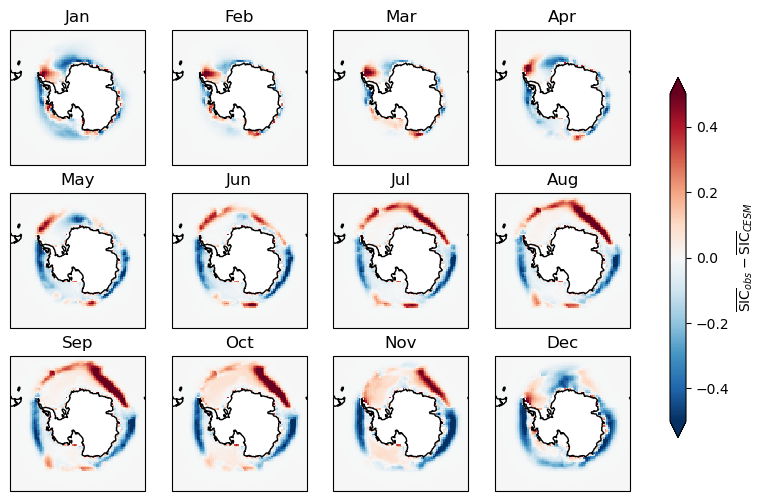

In [14]:
import cartopy.crs as ccrs
fig, axs = plt.subplots(nrows=3, ncols=4, figsize=(8,6), sharex=True, sharey=True,
                        subplot_kw={'projection': ccrs.SouthPolarStereo()})
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
            'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
lon = reference_grid.lon.data
lat = reference_grid.lat.data

clim_cesm = clim_cesm.where(~clim_obs.isnull())

axs = axs.flatten()
for i in range(12): 
    axs[i].set_title(months[i])
    cax = axs[i].pcolormesh(lon, lat, (clim_obs - clim_cesm).isel(month=i), transform=ccrs.PlateCarree(), cmap="RdBu_r", vmin=-0.5, vmax=0.5)
    axs[i].coastlines()

cbar_ax = fig.add_axes([0.95, 0.2, 0.02, 0.6]) 

fig.colorbar(cax, cax=cbar_ax, orientation='vertical', extend="both", 
            label=r'$\overline{\mathrm{SIC}}_{obs} - \overline{\mathrm{SIC}}_{CESM}$')
plt.savefig("figures/cesm/exp3_cesm_clim_bias.jpg", dpi=300, bbox_inches='tight')
    